In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json

In [19]:
config_file = '../checkpoints/carpart_phase_2/carpart_pseudo.py'
checkpoint_file = '../checkpoints/carpart_rear_exp_1/epoch_26.pth'

In [20]:
#torch.cuda.set_device(1)

In [21]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [5]:
path = Path('../data/carpart')

In [6]:
test = json.load(open(path/'annotations'/'test.json'))
print(len(test['images']))

983


In [7]:
cates = []
for a in test['categories']:
    cates.append(a['name'])
cates = cates[1:]
cates.append('none')
print(cates)
len(cates)

['sli_side_turn_light', 'tyre', 'alloy_wheel', 'hli_head_light', 'hood', 'fwi_windshield', 'flp_front_license_plate', 'door', 'mirror', 'handle', 'qpa_quarter_panel', 'fender', 'grille', 'fbu_front_bumper', 'rocker_panel', 'rbu_rear_bumper', 'pillar', 'roof', 'blp_back_license_plate', 'window', 'rwi_rear_windshield', 'tail_gate', 'tli_tail_light', 'fbe_fog_light_bezel', 'fli_fog_light', 'fuel_tank_door', 'lli_low_bumper_tail_light', 'none']


28

In [23]:
# show the results
#img_,bboxs,segms,labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.6)

In [24]:
#plt.figure(figsize=(20,10))
#plt.imshow(img_)

In [22]:
conf_matrix = np.zeros((28,28)).astype(np.int32)
print(conf_matrix)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [23]:
def cal_iou(img,box1,box2):
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    original_labels = gt_labels.copy()
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        check = 1
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.5 :
                tp += 1
                conf_matrix[pred_labels[i],pred_labels[i]] += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_boxes[idx] = -1
                gt_labels[idx] = -1
                check = 0
                break
        
        if check :
            i_gt_boxes = [m for (m,n) in zip(gt_boxes,original_labels) if n != pred_labels[i]]
            i_gt_labels = [n for (m,n) in zip(gt_boxes,original_labels) if n != pred_labels[i]]
            
            check_fp = 1
            for j in range(len(i_gt_boxes)):
                iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
                if iou > 0.5:
                    print(name)
                    print(cates[i_gt_labels[j]],cates[pred_labels[i]])
                    conf_matrix[i_gt_labels[j],pred_labels[i]] += 1
                    check_fp = 0
                    break
            
            if check_fp:
                conf_matrix[-1,pred_labels[i]] += 1
    
    for i in range(len(gt_labels)):
        if gt_labels[i] != -1:
            conf_matrix[gt_labels[i],-1] += 1
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

def cal_iou_segm(segm1,segm2):
    intersect = np.logical_and(segm1,segm2)
    union = np.logical_or(segm1,segm2)
    
    if union.sum() == 0:
        return 0
    
    return intersect.sum() / union.sum()

def cal_ap(pred_segms, pred_labels, gt_segms, gt_labels,name):
    tps = [0 for i in range(len(cates) - 1)]
    preds = [0 for i in range(len(cates) - 1)]
    for i in range(len(tps)):
        i_pred_segms = [m for (m,n) in zip(pred_segms,pred_labels) if n == i]
        i_gt_segms = [m for (m,n) in zip(gt_segms,gt_labels) if n == i]
        
        for j in range(len(i_pred_segms)):
            check_fp = 1
            for z in range(len(i_gt_segms)):
                if cal_iou_segm(i_pred_segms[j],i_gt_segms[z]) > 0.5:
                    tps[i] += 1
                    i_gt_segms[z][:,:] = False
                    check_fp = 0
            
            if check_fp:
                if cates[i] in fp_dict.keys():
                    fp_dict[cates[i]].append(name)
                else:
                    fp_dict[cates[i]] = [name]
        
        preds[i] = len(i_pred_segms)
    
    return tps, preds 

def get_idx(li,value):
    for i in range(len(li)):
        if np.array_equal(li[i],value):
            return i

def plot_fp(name,lb):
    image = cv2.imread(str(path/'images'/name))
    mask = np.zeros_like(image[:,:,0])
    i = [i for i in test['images'] if i['file_name']==name][0]
    
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    orgin_segms = gt_segms.copy()
    gt_segms = [cv2.fillPoly(mask.copy(),[segm],1).astype(bool)  for segm in gt_segms]
    
    result = inference_detector(model, image.copy())
    image_out,pred_boxes,pred_segms,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    pred_tp = [0 for i in pred_segms]
    gt_tp = [0 for i in gt_segms]
       
    #orgin_segms = gt_segms.copy()
    orgin_boxes = gt_boxes.copy()
    
    for i in range(len(pred_segms)):
        i_gt_segms = [m for (m,n) in zip(gt_segms,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_segms)):
            iou = cal_iou_segm(pred_segms[i],i_gt_segms[j])
            if iou > 0.5 :
                #return i_gt_segms[j], gt_segms
                idx = get_idx(gt_segms,i_gt_segms[j])
                #gt_segms.index(i_gt_segms[j])
                gt_segms[idx] = -1
                #gt_labels[idx] = -1
                gt_tp[idx] = 1
                pred_tp[i] = 1
                break 
    for i in range(len(pred_tp)):
        if pred_tp[i]==0:
            image_out = cv2.rectangle(image_out,pred_boxes[i][0],pred_boxes[i][1],(255,0,0),2)
            if pred_labels[i] == lb:
                image_out[pred_segms[i]] = (255,255,0)
    
    for i in range(len(gt_tp)):
        if gt_tp[i]==1:
            pass
            #image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(0,255,0),2)
        else:
            #image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(255,0,0),2)
            if gt_labels[i] == lb :
                image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(255,0,0),2)
                image = cv2.fillPoly(image,[orgin_segms[i]],(255,255,0))
    
    out = np.hstack((image_out,image))
    #plt.figure(figsize=(20,10))
    #plt.axis('off')
    #plt.imshow(out)
    
    return out


In [24]:
total_tp ,total_fp,total_fn = 0,0,0
conf_matrix[:,:] = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    print(i['file_name'])
    
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]

    result = inference_detector(model, image)
    _,pred_boxs,_,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    tp,fp,fn = cal(image,pred_boxs,pred_labels,gt_boxes,gt_labels,i['file_name'])
    
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    print(tp,fp,fn)
    #print(conf_matrix.sum())
    #print(conf_matrix)
    #break

print('sum tp :',total_tp,' fp :',total_fp,' fn : ',total_fn)
    

  0%|                                                                                                                                                      | 0/983 [00:00<?, ?it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_564_IMG_4152.JPG


  0%|▏                                                                                                                                             | 1/983 [00:00<04:23,  3.72it/s]

23 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_31_DSCN0619.JPG


  0%|▎                                                                                                                                             | 2/983 [00:02<12:17,  1.33it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067882.jpg


  0%|▍                                                                                                                                             | 3/983 [00:02<12:25,  1.32it/s]

31 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0956.JPG


  0%|▌                                                                                                                                             | 4/983 [00:03<09:54,  1.65it/s]

24 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_237_IMG-20181001-WA0044.jpg


  1%|▊                                                                                                                                             | 6/983 [00:03<06:17,  2.59it/s]

6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_402_IMG_4584.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817755_img2058917.jpg


  1%|█                                                                                                                                             | 7/983 [00:03<05:05,  3.20it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8103.JPG


  1%|█▎                                                                                                                                            | 9/983 [00:05<08:58,  1.81it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5176.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_528_IMG_7758.JPG


  1%|█▍                                                                                                                                           | 10/983 [00:05<07:15,  2.24it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_610_IMG-20171117-WA0072.jpg


  1%|█▋                                                                                                                                           | 12/983 [00:06<05:24,  2.99it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_877_IMG_2804.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111828782_img2360403.jpg


  1%|█▊                                                                                                                                           | 13/983 [00:06<05:53,  2.74it/s]

24 5 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_486_IMG_5531.JPG


  1%|██                                                                                                                                           | 14/983 [00:06<05:07,  3.15it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0021.jpg


  2%|██▎                                                                                                                                          | 16/983 [00:07<04:05,  3.94it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_667_IMG_4482.JPG
10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1399.JPG


  2%|██▌                                                                                                                                          | 18/983 [00:08<07:23,  2.17it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_707_IMG_2179.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131905869_img2899583.jpg


  2%|██▊                                                                                                                                          | 20/983 [00:09<05:41,  2.82it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131905869_img2899583.jpg
qpa_quarter_panel door
9 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1057_DSCN8835.JPG
3 0 0


  2%|███                                                                                                                                          | 21/983 [00:09<04:55,  3.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_753_IMG_7382.JPG
14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1474_DSCN5697.JPG


  2%|███▎                                                                                                                                         | 23/983 [00:10<04:42,  3.40it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1474_DSCN5697.JPG
fender qpa_quarter_panel
6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8634.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8634.JPG
door handle
21 1 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1072_IMG-20180824-WA0054.jpg


  2%|███▍                                                                                                                                         | 24/983 [00:10<04:11,  3.81it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_906_IMG_2336.JPG


  3%|███▋                                                                                                                                         | 26/983 [00:10<03:32,  4.51it/s]

15 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_464_IMG_2250.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_551_IMG_7778.JPG


  3%|███▊                                                                                                                                         | 27/983 [00:10<03:19,  4.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_551_IMG_7778.JPG
rbu_rear_bumper fbu_front_bumper
4 2 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010121822338_img2296435.jpg


  3%|████                                                                                                                                         | 28/983 [00:13<12:39,  1.26it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010121822338_img2296435.jpg
door window
27 3 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_22_DSCN9291.JPG


  3%|████▎                                                                                                                                        | 30/983 [00:14<12:16,  1.29it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901385_img2899401.jpg
10 0 0


  3%|████▍                                                                                                                                        | 31/983 [00:14<09:24,  1.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_573_IMG_1566.JPG
9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1380.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1380.JPG
rocker_panel fender


  3%|████▋                                                                                                                                        | 33/983 [00:16<09:22,  1.69it/s]

7 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_560_IMG_0199.JPG
3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_510_IMG_2320.JPG


  4%|█████                                                                                                                                        | 35/983 [00:16<06:17,  2.51it/s]

5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_774_IMG_3611.JPG
10 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_139_Crash+(4).jpg


  4%|█████▎                                                                                                                                       | 37/983 [00:17<05:15,  3.00it/s]

28 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_577_IMG_9880.JPG
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801068_img1750460.jpg


  4%|█████▌                                                                                                                                       | 39/983 [00:18<05:26,  2.89it/s]

10 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1281_DSCN8456.JPG
6 0 0


  4%|█████▋                                                                                                                                       | 40/983 [00:18<04:40,  3.36it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_954_IMG_0179.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0027.jpg


  4%|█████▉                                                                                                                                       | 41/983 [00:18<05:09,  3.04it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0027.jpg
handle door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0027.jpg
fli_fog_light fbe_fog_light_bezel
28 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_560_IMG_0201.JPG


  4%|██████                                                                                                                                       | 42/983 [00:19<05:08,  3.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_560_IMG_0201.JPG
tail_gate qpa_quarter_panel
24 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0008+mark+(1).jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0008+mark+(1).jpg
tli_tail_light hli_head_light


  4%|██████▏                                                                                                                                      | 43/983 [00:19<06:04,  2.58it/s]

16 6 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_288_DSCN3029mark+(2).JPG


  4%|██████▎                                                                                                                                      | 44/983 [00:20<10:47,  1.45it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818512_img2079327.jpg


  5%|██████▍                                                                                                                                      | 45/983 [00:21<10:37,  1.47it/s]

21 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2439611.jpg


  5%|██████▌                                                                                                                                      | 46/983 [00:21<09:16,  1.68it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_552_IMG_5495.JPG


  5%|██████▉                                                                                                                                      | 48/983 [00:22<05:58,  2.61it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_939_IMG_5892.JPG
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_107_IMG_20170522_150636.jpg


  5%|███████                                                                                                                                      | 49/983 [00:23<08:49,  1.76it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_181_IMG_5703mark+(4).jpg


  5%|███████▎                                                                                                                                     | 51/983 [00:23<06:04,  2.55it/s]

8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_479_IMG_7365.JPG
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801015_img1743935.jpg


  5%|███████▍                                                                                                                                     | 52/983 [00:24<07:23,  2.10it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_235_IMG-20181010-WA0083.jpg
6 1 8


  5%|███████▌                                                                                                                                     | 53/983 [00:24<06:05,  2.54it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1069_PHOTO-2018-08-12-16-20-52.jpg


  5%|███████▋                                                                                                                                     | 54/983 [00:25<06:50,  2.26it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1069_PHOTO-2018-08-12-16-20-52.jpg
window fwi_windshield
29 4 5
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900509_img2782438.jpg


  6%|███████▉                                                                                                                                     | 55/983 [00:25<06:47,  2.28it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_81_DSCN0120.JPG


  6%|████████▏                                                                                                                                    | 57/983 [00:28<12:01,  1.28it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1213_IMG_20180911_104214-409x307.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1213_IMG_20180911_104214-409x307.jpg
door qpa_quarter_panel
23 4 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140417.jpg


  6%|████████▍                                                                                                                                    | 59/983 [00:28<07:28,  2.06it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6715.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6715.JPG
flp_front_license_plate blp_back_license_plate
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6715.JPG
grille fbe_fog_light_bezel
5 2 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817833_img2060864.jpg


  6%|████████▌                                                                                                                                    | 60/983 [00:28<05:56,  2.59it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826265_img2290590.jpg


  6%|████████▋                                                                                                                                    | 61/983 [00:29<06:14,  2.46it/s]

9 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900576_img2793795.jpg


  6%|████████▉                                                                                                                                    | 62/983 [00:30<07:26,  2.06it/s]

25 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_867_IMG_9130.JPG


  6%|█████████                                                                                                                                    | 63/983 [00:30<06:14,  2.45it/s]

7 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141953.jpg


  7%|█████████▎                                                                                                                                   | 65/983 [00:30<04:27,  3.43it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_917_IMG_0911.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_374_IMG-20180418-WA0022.jpg


  7%|█████████▍                                                                                                                                   | 66/983 [00:30<03:51,  3.96it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906605_img2921388.jpg


  7%|█████████▌                                                                                                                                   | 67/983 [00:31<04:35,  3.32it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_318_IMG-20190201-WA0117.jpg


  7%|█████████▊                                                                                                                                   | 68/983 [00:31<04:10,  3.65it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901375_img2896810.jpg


  7%|█████████▉                                                                                                                                   | 69/983 [00:31<04:21,  3.49it/s]

22 1 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818472_img2078435.jpg


  7%|██████████                                                                                                                                   | 70/983 [00:32<05:21,  2.84it/s]

9 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111906354_img2914277.jpg


  7%|██████████▎                                                                                                                                  | 72/983 [00:33<06:01,  2.52it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_668_IMG_9498.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818594_img2081124.jpg


  7%|██████████▍                                                                                                                                  | 73/983 [00:33<06:24,  2.37it/s]

12 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906722_img2924353.jpg


  8%|██████████▊                                                                                                                                  | 75/983 [00:34<04:57,  3.05it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_665_IMG_2875.JPG
11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_391_IMG_4697.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_391_IMG_4697.JPG
window door


  8%|███████████                                                                                                                                  | 77/983 [00:40<21:17,  1.41s/it]

21 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_513_IMG_4239.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0019.jpg


  8%|███████████▏                                                                                                                                 | 78/983 [00:40<15:29,  1.03s/it]

3 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817949_img2064383.jpg


  8%|███████████▎                                                                                                                                 | 79/983 [00:40<13:33,  1.11it/s]

23 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_293_IMG_7160MARK+(6).jpg


  8%|███████████▌                                                                                                                                 | 81/983 [00:41<08:54,  1.69it/s]

26 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_84_IMG-20170602-WA0013.jpg
2 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1301_20130415_122910.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1301_20130415_122910.jpg
window handle


  8%|███████████▊                                                                                                                                 | 82/983 [00:42<13:04,  1.15it/s]

13 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1180_IMG_20181227_161723.jpg


  8%|███████████▉                                                                                                                                 | 83/983 [00:43<11:39,  1.29it/s]

14 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801259_img1771066.jpg


  9%|████████████                                                                                                                                 | 84/983 [00:43<10:02,  1.49it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0232.JPG


  9%|████████████▏                                                                                                                                | 85/983 [00:46<17:07,  1.14s/it]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0032.jpg


  9%|████████████▎                                                                                                                                | 86/983 [00:46<13:02,  1.15it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1142_DSCN2481mark+(3).JPG


  9%|████████████▍                                                                                                                                | 87/983 [00:46<10:07,  1.47it/s]

6 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_610_IMG-20171117-WA0073.jpg


  9%|████████████▌                                                                                                                                | 88/983 [00:46<08:28,  1.76it/s]

13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_681_IMG_4595.JPG


  9%|████████████▊                                                                                                                                | 89/983 [00:47<06:53,  2.16it/s]

13 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829333_img2375623.jpg


  9%|████████████▉                                                                                                                                | 90/983 [00:48<11:07,  1.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829333_img2375623.jpg
rwi_rear_windshield fwi_windshield
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829333_img2375623.jpg
qpa_quarter_panel fender
3 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_509_IMG_4770.JPG


  9%|█████████████▏                                                                                                                               | 92/983 [00:48<06:50,  2.17it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_938_IMG_3766.JPG
7 0 0


  9%|█████████████▎                                                                                                                               | 93/983 [00:49<05:37,  2.64it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_789_IMG_7206.JPG
8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_855_IMG_5643.JPG


 10%|█████████████▍                                                                                                                               | 94/983 [00:49<04:41,  3.16it/s]

5 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_608_TimePhoto_20180508_161016.jpg


 10%|█████████████▋                                                                                                                               | 95/983 [00:49<04:26,  3.33it/s]

7 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1225_IMG20190224_1314291600074058249924621.jpg


 10%|█████████████▊                                                                                                                               | 96/983 [00:49<04:02,  3.66it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1225_IMG20190224_1314291600074058249924621.jpg
fbu_front_bumper fender
2 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_959_IMG_4481.JPG


 10%|██████████████                                                                                                                               | 98/983 [00:50<03:25,  4.31it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_773_IMG_4034.JPG
10 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1274_DSCN8492.JPG


 10%|██████████████▏                                                                                                                              | 99/983 [00:51<09:48,  1.50it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1274_DSCN8492.JPG
tail_gate tli_tail_light
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1500_DSCN5022.JPG


 10%|██████████████▍                                                                                                                             | 101/983 [00:53<09:14,  1.59it/s]

25 4 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_461_IMG_5359.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4723.JPG


 10%|██████████████▋                                                                                                                             | 103/983 [00:53<06:04,  2.41it/s]

29 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_745_IMG_5309.JPG
13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_474_IMG_6847.JPG


 11%|██████████████▉                                                                                                                             | 105/983 [00:54<04:14,  3.46it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_717_IMG_4082.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_947_IMG_4328.JPG


 11%|███████████████                                                                                                                             | 106/983 [00:54<03:42,  3.95it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_850_IMG_5813.JPG


 11%|███████████████▏                                                                                                                            | 107/983 [00:54<03:50,  3.80it/s]

16 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_679_IMG_6555.JPG


 11%|███████████████▍                                                                                                                            | 108/983 [00:54<04:46,  3.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_679_IMG_6555.JPG
tyre alloy_wheel
37 3 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_521_IMG_1524.JPG


 11%|███████████████▌                                                                                                                            | 109/983 [00:55<04:08,  3.52it/s]

10 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1106_IMG-20180922-WA0042.jpg


 11%|███████████████▋                                                                                                                            | 110/983 [00:55<03:55,  3.71it/s]

3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_194_IMG-20180922-WA0051.jpg


 11%|███████████████▊                                                                                                                            | 111/983 [00:55<04:09,  3.50it/s]

11 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111828538_img2353990.jpg


 11%|███████████████▉                                                                                                                            | 112/983 [00:56<07:41,  1.89it/s]

4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_3_DSCN9172.JPG


 12%|████████████████▏                                                                                                                           | 114/983 [00:59<12:18,  1.18it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1291_DSCN9079.JPG
20 0 8


 12%|████████████████▍                                                                                                                           | 115/983 [00:59<09:32,  1.52it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900782_img2822173.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_602_IMG_1450.JPG


 12%|████████████████▌                                                                                                                           | 116/983 [00:59<07:36,  1.90it/s]

14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1113_DSCN2736mark+(5).JPG


 12%|████████████████▊                                                                                                                           | 118/983 [01:04<17:35,  1.22s/it]

22 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153207.jpg
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922885.jpg


 12%|████████████████▉                                                                                                                           | 119/983 [01:04<14:29,  1.01s/it]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922885.jpg
qpa_quarter_panel fender
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922885.jpg
rbu_rear_bumper fbu_front_bumper
10 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_95_DSCN0586.JPG


 12%|█████████████████                                                                                                                           | 120/983 [01:07<20:22,  1.42s/it]

10 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907055_img2934705.jpg


 12%|█████████████████▏                                                                                                                          | 121/983 [01:07<15:36,  1.09s/it]

5 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_99_DSC06866.JPG


 12%|█████████████████▍                                                                                                                          | 122/983 [01:07<11:49,  1.21it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_631_IMG_9503.JPG


 13%|█████████████████▌                                                                                                                          | 123/983 [01:08<09:14,  1.55it/s]

5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_138_IMG_2462.jpg


 13%|█████████████████▋                                                                                                                          | 124/983 [01:08<07:58,  1.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_138_IMG_2462.jpg
door window
27 4 12
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_75_IMG_20180511_142311.jpg


 13%|█████████████████▊                                                                                                                          | 125/983 [01:10<13:12,  1.08it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_980_DSCN4686.JPG


 13%|█████████████████▉                                                                                                                          | 126/983 [01:14<29:12,  2.04s/it]

27 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1382.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1382.JPG
handle sli_side_turn_light


 13%|██████████████████                                                                                                                          | 127/983 [01:16<26:11,  1.84s/it]

9 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_123_IMG_20180119_104537.jpg


 13%|██████████████████▏                                                                                                                         | 128/983 [01:16<19:27,  1.37s/it]

14 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_612_IMG_7416.JPG


 13%|██████████████████▎                                                                                                                         | 129/983 [01:16<14:34,  1.02s/it]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_791_TimePhoto_20180912_131539.jpg


 13%|██████████████████▌                                                                                                                         | 130/983 [01:17<11:52,  1.20it/s]

28 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_142656.jpg


 13%|██████████████████▊                                                                                                                         | 132/983 [01:17<07:21,  1.93it/s]

17 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_749_IMG_0824.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_615_IMG_5037.JPG


 14%|██████████████████▉                                                                                                                         | 133/983 [01:17<06:49,  2.08it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_615_IMG_5037.JPG
hli_head_light sli_side_turn_light
33 3 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1111_IMG_1756.jpg


 14%|███████████████████▏                                                                                                                        | 135/983 [01:18<04:48,  2.94it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1111_IMG_1756.jpg
hood fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1111_IMG_1756.jpg
fbu_front_bumper rbu_rear_bumper
2 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_917_IMG_0930.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8653.JPG


 14%|███████████████████▌                                                                                                                        | 137/983 [01:18<03:36,  3.90it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1228_IMG_20180808_141410.jpg
9 0 0


 14%|███████████████████▋                                                                                                                        | 138/983 [01:18<03:12,  4.39it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_846_IMG_8182.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_475_IMG_0716.JPG


 14%|███████████████████▊                                                                                                                        | 139/983 [01:19<02:57,  4.76it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111828049_img2508854.jpg


 14%|███████████████████▉                                                                                                                        | 140/983 [01:20<08:42,  1.61it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145828.jpg


 14%|████████████████████                                                                                                                        | 141/983 [01:21<07:58,  1.76it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8360.JPG


 14%|████████████████████▏                                                                                                                       | 142/983 [01:21<07:05,  1.98it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8360.JPG
hli_head_light fbu_front_bumper
32 3 11
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_596_IMG_0204.JPG


 15%|████████████████████▌                                                                                                                       | 144/983 [01:21<05:12,  2.69it/s]

32 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_473_IMG_9193.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_183941mark+(4).jpg


 15%|████████████████████▋                                                                                                                       | 145/983 [01:22<06:01,  2.32it/s]

24 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1218_IMG20181113_162606435449010.jpg


 15%|████████████████████▊                                                                                                                       | 146/983 [01:22<05:26,  2.57it/s]

7 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1050_IMG-20180806-WA0108mark+(3).jpg


 15%|████████████████████▉                                                                                                                       | 147/983 [01:23<05:01,  2.77it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_539_TimePhoto_20180422_140219.jpg


 15%|█████████████████████                                                                                                                       | 148/983 [01:23<04:25,  3.15it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_992_DSCN8227mark+(1).JPG


 15%|█████████████████████▏                                                                                                                      | 149/983 [01:23<04:24,  3.15it/s]

15 4 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2575mark+(3).JPG


 15%|█████████████████████▌                                                                                                                      | 151/983 [01:24<03:38,  3.80it/s]

28 0 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1254_IMG_5055.JPG
12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_478_IMG_4880.JPG


 16%|█████████████████████▊                                                                                                                      | 153/983 [01:24<03:37,  3.81it/s]

20 5 4
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906380_img2915295.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_964_IMG_20180307_152302807.jpg


 16%|██████████████████████                                                                                                                      | 155/983 [01:28<13:49,  1.00s/it]

23 1 10
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1471.jpg
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1112_DSCN2547.JPG


 16%|██████████████████████▏                                                                                                                     | 156/983 [01:30<18:41,  1.36s/it]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_398_100_4016.JPG


 16%|██████████████████████▎                                                                                                                     | 157/983 [01:32<19:32,  1.42s/it]

16 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_658_IMG_9172.JPG


 16%|██████████████████████▋                                                                                                                     | 159/983 [01:33<11:27,  1.20it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_691_IMG_8374.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_196_IMG-20180904-WA0044.jpg


 16%|██████████████████████▊                                                                                                                     | 160/983 [01:33<10:04,  1.36it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1063_IMG-20180824-WA0009MARK+(2).jpg


 16%|██████████████████████▉                                                                                                                     | 161/983 [01:34<09:25,  1.45it/s]

18 5 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3639.JPG


 16%|███████████████████████                                                                                                                     | 162/983 [01:34<07:32,  1.82it/s]

12 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5342.JPG


 17%|███████████████████████▏                                                                                                                    | 163/983 [01:34<06:42,  2.03it/s]

3 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102731+MARK+(5).jpg


 17%|███████████████████████▎                                                                                                                    | 164/983 [01:35<06:46,  2.02it/s]

11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_826_IMG_6986.JPG


 17%|███████████████████████▍                                                                                                                    | 165/983 [01:35<05:42,  2.39it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901024_img2852651.jpg


 17%|███████████████████████▋                                                                                                                    | 166/983 [01:35<05:19,  2.56it/s]

23 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_328_IMG-20180911-WA0047mark+(5).jpg


 17%|███████████████████████▊                                                                                                                    | 167/983 [01:36<05:00,  2.72it/s]

13 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901427_img2905369.jpg


 17%|███████████████████████▉                                                                                                                    | 168/983 [01:36<04:28,  3.04it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_713_IMG_5305.JPG


 17%|████████████████████████▏                                                                                                                   | 170/983 [01:36<03:40,  3.69it/s]

15 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_648_TimePhoto_20180417_173535.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_263_IMG_20180410_152708.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_263_IMG_20180410_152708.jpg
rwi_rear_windshield fwi_windshield


 17%|████████████████████████▎                                                                                                                   | 171/983 [01:37<03:32,  3.82it/s]

22 1 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_734_IMG_7738.JPG


 17%|████████████████████████▍                                                                                                                   | 172/983 [01:37<03:27,  3.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_734_IMG_7738.JPG
rwi_rear_windshield fwi_windshield
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_734_IMG_7738.JPG
rwi_rear_windshield tail_gate
15 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_639_IMG_9366.JPG


 18%|████████████████████████▋                                                                                                                   | 173/983 [01:37<03:06,  4.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_639_IMG_9366.JPG
grille fbu_front_bumper
3 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_364_DSCN6949.JPG


 18%|████████████████████████▊                                                                                                                   | 174/983 [01:37<03:04,  4.39it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_642_IMG_5527.jpg


 18%|████████████████████████▉                                                                                                                   | 175/983 [01:38<03:53,  3.46it/s]

23 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1476_IMG-20181120-WA0014.jpg


 18%|█████████████████████████                                                                                                                   | 176/983 [01:39<06:41,  2.01it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_940_TimePhoto_20180301_171109.jpg


 18%|█████████████████████████▎                                                                                                                  | 178/983 [01:39<04:41,  2.86it/s]

10 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_492_IMG_0062.JPG
11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1098_IMG-20180903-WA0019.jpg


 18%|█████████████████████████▋                                                                                                                  | 180/983 [01:40<04:22,  3.05it/s]

5 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818503_img2079048.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1279_WhatsApp+Image+2019-03-12+at+4.22.25+PM+(1).jpeg


 18%|█████████████████████████▊                                                                                                                  | 181/983 [01:40<04:02,  3.30it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111916208_img3213799.jpg


 19%|██████████████████████████                                                                                                                  | 183/983 [01:40<03:26,  3.88it/s]

25 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1175_DSCN6574.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1349_IMG-20160531-WA0018.jpg


 19%|██████████████████████████▎                                                                                                                 | 185/983 [01:41<03:08,  4.23it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_817_IMG_2967.JPG
11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_542_IMG_0534.JPG


 19%|██████████████████████████▍                                                                                                                 | 186/983 [01:41<02:46,  4.80it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_809_IMG_8507.JPG


 19%|██████████████████████████▋                                                                                                                 | 187/983 [01:41<02:52,  4.60it/s]

14 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4094.JPG


 19%|██████████████████████████▊                                                                                                                 | 188/983 [01:44<14:06,  1.07s/it]

23 3 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_293_IMG_7160MARK+(3).jpg


 19%|███████████████████████████                                                                                                                 | 190/983 [01:45<08:19,  1.59it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_293_IMG_7160MARK+(3).jpg
mirror fuel_tank_door
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_555_IMG_8937.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_200_IMG-20180919-WA0013.jpg


 19%|███████████████████████████▏                                                                                                                | 191/983 [01:45<07:12,  1.83it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_200_IMG-20180919-WA0013.jpg
door fender
2 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800967_img1738888.jpg


 20%|███████████████████████████▎                                                                                                                | 192/983 [01:45<06:38,  1.99it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801041_img1747104.jpg


 20%|███████████████████████████▍                                                                                                                | 193/983 [01:47<08:47,  1.50it/s]

30 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131905974_img2902345.jpg


 20%|███████████████████████████▋                                                                                                                | 194/983 [01:47<07:16,  1.81it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_934_IMG_20180629_135316.jpg


 20%|███████████████████████████▊                                                                                                                | 195/983 [01:47<06:29,  2.03it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_934_IMG_20180629_135316.jpg
handle door
24 1 5
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815880.jpg


 20%|███████████████████████████▉                                                                                                                | 196/983 [01:48<06:38,  1.97it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_437_TimePhoto_20180505_141041.jpg


 20%|████████████████████████████                                                                                                                | 197/983 [01:48<05:41,  2.30it/s]

13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_535_IMG_7740.JPG


 20%|████████████████████████████▏                                                                                                               | 198/983 [01:48<05:27,  2.40it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_189_DSCN8575.JPG


 20%|████████████████████████████▎                                                                                                               | 199/983 [01:51<13:16,  1.02s/it]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1279_mark+photos+(2).jpeg


 20%|████████████████████████████▍                                                                                                               | 200/983 [01:51<10:26,  1.25it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_507_photo+008.jpg


 21%|████████████████████████████▊                                                                                                               | 202/983 [01:52<07:43,  1.68it/s]

30 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153414.jpg
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_483_IMG_8327.JPG


 21%|████████████████████████████▉                                                                                                               | 203/983 [01:52<06:17,  2.07it/s]

13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826102_img2285359.jpg


 21%|█████████████████████████████                                                                                                               | 204/983 [01:54<09:44,  1.33it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_945_IMG_6667.JPG


 21%|█████████████████████████████▏                                                                                                              | 205/983 [01:54<07:43,  1.68it/s]

13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_883_IMG_1556.JPG


 21%|█████████████████████████████▍                                                                                                              | 207/983 [01:54<05:03,  2.56it/s]

14 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_573_IMG_1573.JPG
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906735_img2924800.jpg


 21%|█████████████████████████████▌                                                                                                              | 208/983 [01:55<05:19,  2.43it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0237.JPG


 21%|█████████████████████████████▊                                                                                                              | 209/983 [01:55<04:48,  2.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0237.JPG
hli_head_light tli_tail_light
8 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_374_IMG-20180418-WA0013.jpg


 21%|██████████████████████████████                                                                                                              | 211/983 [01:55<03:48,  3.38it/s]

25 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_861_TimePhoto_20180511_171240.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_813_IMG_0364.JPG


 22%|██████████████████████████████▏                                                                                                             | 212/983 [01:56<03:18,  3.88it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1262_DSCN8411.JPG


 22%|██████████████████████████████▎                                                                                                             | 213/983 [01:58<10:48,  1.19it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1262_DSCN8411.JPG
tyre qpa_quarter_panel
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_993_IMG_20180806_174420.jpg


 22%|██████████████████████████████▌                                                                                                             | 215/983 [01:58<06:49,  1.88it/s]

13 1 16
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1224_IMG20190224_1305341642929732158838529.jpg
3 0 0


 22%|██████████████████████████████▊                                                                                                             | 216/983 [01:58<05:36,  2.28it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_605_IMG_7639.JPG
8 2 0


 22%|██████████████████████████████▉                                                                                                             | 217/983 [01:59<04:29,  2.85it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_886_IMG_1934.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1182_DSCN6508.JPG


 22%|███████████████████████████████                                                                                                             | 218/983 [01:59<04:44,  2.69it/s]

2 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1135_DSCN2328.JPG


 22%|███████████████████████████████▏                                                                                                            | 219/983 [01:59<04:20,  2.94it/s]

12 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1073_IMG-20180823-WA0036.jpg


 22%|███████████████████████████████▍                                                                                                            | 221/983 [02:01<05:40,  2.24it/s]

5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_603_IMG_0611.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_885_IMG_8029.JPG


 23%|███████████████████████████████▌                                                                                                            | 222/983 [02:01<04:43,  2.68it/s]

12 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_906_IMG_2337.JPG


 23%|███████████████████████████████▉                                                                                                            | 224/983 [02:01<03:35,  3.53it/s]

26 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_737_IMG_0479.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_205_IMG-20180926-WA0103MARK+(4).jpg


 23%|████████████████████████████████                                                                                                            | 225/983 [02:01<03:19,  3.80it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_22_DSCN9295.JPG


 23%|████████████████████████████████▏                                                                                                           | 226/983 [02:03<09:04,  1.39it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_22_DSCN9295.JPG
rbu_rear_bumper qpa_quarter_panel
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1283_100_3553.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1283_100_3553.JPG
sli_side_turn_light tyre


 23%|████████████████████████████████▎                                                                                                           | 227/983 [02:06<16:44,  1.33s/it]

25 2 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_659_IMG_2959.JPG


 23%|████████████████████████████████▍                                                                                                           | 228/983 [02:06<12:38,  1.00s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_659_IMG_2959.JPG
fbe_fog_light_bezel grille
12 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_273_IMG-20181110-WA0072+mark+1+(4).jpg


 23%|████████████████████████████████▌                                                                                                           | 229/983 [02:07<10:19,  1.22it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_905_IMG_4898.JPG


 23%|████████████████████████████████▊                                                                                                           | 230/983 [02:07<08:03,  1.56it/s]

19 0 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131827022_img2310825.jpg


 23%|████████████████████████████████▉                                                                                                           | 231/983 [02:08<10:02,  1.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131827022_img2310825.jpg
grille fbe_fog_light_bezel
39 2 11
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901009_img2850188.jpg


 24%|█████████████████████████████████                                                                                                           | 232/983 [02:08<08:38,  1.45it/s]

11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906696_img2923751.jpg


 24%|█████████████████████████████████▏                                                                                                          | 233/983 [02:09<07:12,  1.74it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906696_img2923751.jpg
fbe_fog_light_bezel grille
3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1062_IMG-20180830-WA0004mark+(4).jpg


 24%|█████████████████████████████████▎                                                                                                          | 234/983 [02:09<05:56,  2.10it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1062_IMG-20180830-WA0004mark+(4).jpg
door hood
5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1173_DSCN6622.JPG


 24%|█████████████████████████████████▍                                                                                                          | 235/983 [02:10<06:47,  1.83it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1173_DSCN6622.JPG
fender fbu_front_bumper
17 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2758.JPG


 24%|█████████████████████████████████▌                                                                                                          | 236/983 [02:10<05:34,  2.23it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1046_IMG_9061.jpg


 24%|█████████████████████████████████▉                                                                                                          | 238/983 [02:11<04:54,  2.53it/s]

15 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_573_IMG_1680.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815871.jpg


 24%|██████████████████████████████████                                                                                                          | 239/983 [02:11<05:05,  2.44it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_51_DSCN0643.JPG


 24%|██████████████████████████████████▏                                                                                                         | 240/983 [02:15<17:55,  1.45s/it]

22 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1068_IMG-20180821-WA0011.jpg


 25%|██████████████████████████████████▎                                                                                                         | 241/983 [02:15<13:53,  1.12s/it]

15 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_973_IMG_20180804_133533.jpg


 25%|██████████████████████████████████▍                                                                                                         | 242/983 [02:16<11:13,  1.10it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_973_IMG_20180804_133533.jpg
fbe_fog_light_bezel grille
32 1 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_216_IMG-20180926-WA0031MARK+(6).jpg


 25%|██████████████████████████████████▊                                                                                                         | 244/983 [02:16<06:43,  1.83it/s]

5 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_453_TimePhoto_20180206_143841.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_672_IMG_4841.JPG


 25%|██████████████████████████████████▉                                                                                                         | 245/983 [02:17<06:00,  2.05it/s]

33 0 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_800_IMG_5215.JPG


 25%|███████████████████████████████████                                                                                                         | 246/983 [02:17<05:18,  2.32it/s]

22 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1340_IMG_20180824_143256.jpg


 25%|███████████████████████████████████▏                                                                                                        | 247/983 [02:17<04:50,  2.54it/s]

11 4 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0026.jpg


 25%|███████████████████████████████████▎                                                                                                        | 248/983 [02:17<04:32,  2.70it/s]

13 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1183_IMG_20181227_170831.jpg


 25%|███████████████████████████████████▍                                                                                                        | 249/983 [02:18<04:21,  2.81it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1164_DSCN2048.JPG


 25%|███████████████████████████████████▌                                                                                                        | 250/983 [02:20<09:51,  1.24it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_254_WhatsApp+Image+2018-11-23+at+9.40.09+AM.jpeg


 26%|███████████████████████████████████▋                                                                                                        | 251/983 [02:20<07:48,  1.56it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815872.jpg


 26%|███████████████████████████████████▉                                                                                                        | 252/983 [02:20<07:04,  1.72it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102821.jpg


 26%|████████████████████████████████████                                                                                                        | 253/983 [02:21<06:49,  1.78it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_562_IMG_6392.JPG


 26%|████████████████████████████████████▏                                                                                                       | 254/983 [02:21<05:41,  2.14it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_562_IMG_6392.JPG
tail_gate rwi_rear_windshield
18 3 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800985_img1740284.jpg


 26%|████████████████████████████████████▎                                                                                                       | 255/983 [02:22<05:41,  2.13it/s]

9 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_504_IMG_0823.JPG


 26%|████████████████████████████████████▍                                                                                                       | 256/983 [02:22<05:03,  2.39it/s]

25 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_682_TimePhoto_20180424_134625.jpg


 26%|████████████████████████████████████▌                                                                                                       | 257/983 [02:22<04:44,  2.55it/s]

20 1 15
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901481_img2912602.jpg


 26%|████████████████████████████████████▋                                                                                                       | 258/983 [02:23<04:37,  2.61it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901481_img2912602.jpg
fli_fog_light hli_head_light
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1219_IMG20190221_1825414305467026646523398.jpg


 26%|█████████████████████████████████████                                                                                                       | 260/983 [02:23<03:28,  3.46it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_611_IMG_8150.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_771_DSCN0150.jpg


 27%|█████████████████████████████████████▏                                                                                                      | 261/983 [02:23<04:10,  2.88it/s]

8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_112_DSCN0798.JPG


 27%|█████████████████████████████████████▎                                                                                                      | 262/983 [02:24<03:53,  3.09it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_112_DSCN0798.JPG
tyre door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_112_DSCN0798.JPG
qpa_quarter_panel fender
7 6 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1251_IMG_20170418_130012.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1251_IMG_20170418_130012.jpg
fender tyre


 27%|█████████████████████████████████████▍                                                                                                      | 263/983 [02:25<08:46,  1.37it/s]

9 3 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_126_DSCN3005mark+(3).JPG


 27%|█████████████████████████████████████▌                                                                                                      | 264/983 [02:29<19:41,  1.64s/it]

14 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1155_IMG_20180425_165227.jpg


 27%|█████████████████████████████████████▉                                                                                                      | 266/983 [02:32<16:48,  1.41s/it]

14 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_793_IMG_8463.JPG
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_550_IMG_0944.JPG


 27%|██████████████████████████████████████                                                                                                      | 267/983 [02:32<12:32,  1.05s/it]

11 2 7
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111916244_img3215557.jpg


 27%|██████████████████████████████████████▏                                                                                                     | 268/983 [02:35<19:07,  1.60s/it]

28 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0042.jpg


 27%|██████████████████████████████████████▍                                                                                                     | 270/983 [02:36<10:45,  1.10it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_816_IMG_4969.JPG
7 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1487.jpg


 28%|██████████████████████████████████████▌                                                                                                     | 271/983 [02:36<08:03,  1.47it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1218_IMG20181113_1624451470411063.jpg


 28%|██████████████████████████████████████▉                                                                                                     | 273/983 [02:36<05:16,  2.24it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_608_TimePhoto_20180508_160912.jpg
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1132_DSCN2592.JPG


 28%|███████████████████████████████████████▏                                                                                                    | 275/983 [02:38<08:25,  1.40it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_960_IMG_8807.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_824_IMG_9832.JPG


 28%|███████████████████████████████████████▍                                                                                                    | 277/983 [02:39<05:19,  2.21it/s]

15 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_739_IMG_5664.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826265_img2290593.jpg


 28%|███████████████████████████████████████▌                                                                                                    | 278/983 [02:39<05:23,  2.18it/s]

10 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_733_IMG_6828.JPG


 28%|███████████████████████████████████████▋                                                                                                    | 279/983 [02:40<04:29,  2.61it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1139_DSCN2064.JPG


 28%|███████████████████████████████████████▉                                                                                                    | 280/983 [02:40<03:51,  3.04it/s]

10 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111919364_img3314548.jpg


 29%|████████████████████████████████████████                                                                                                    | 281/983 [02:42<10:25,  1.12it/s]

22 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826078_img2323560.jpg


 29%|████████████████████████████████████████▎                                                                                                   | 283/983 [02:43<08:42,  1.34it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4834.JPG
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_296_DSCN1133mark+(4).JPG


 29%|████████████████████████████████████████▍                                                                                                   | 284/983 [02:46<13:42,  1.18s/it]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0964.JPG


 29%|████████████████████████████████████████▌                                                                                                   | 285/983 [02:46<10:36,  1.10it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0964.JPG
fender qpa_quarter_panel
28 3 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_723_IMG_1290.JPG


 29%|████████████████████████████████████████▋                                                                                                   | 286/983 [02:46<08:03,  1.44it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829890_img2391176.jpg


 29%|█████████████████████████████████████████                                                                                                   | 288/983 [02:47<07:39,  1.51it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_454_IMG_0737.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_188_DSCN3096mark+(6).JPG


 29%|█████████████████████████████████████████▏                                                                                                  | 289/983 [02:49<11:14,  1.03it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_557_IMG_6593.JPG


 30%|█████████████████████████████████████████▎                                                                                                  | 290/983 [02:49<08:39,  1.33it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_557_IMG_6593.JPG
fli_fog_light lli_low_bumper_tail_light
16 2 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_250_IMG-20181119-WA0075mark+(2).jpg


 30%|█████████████████████████████████████████▍                                                                                                  | 291/983 [02:50<07:48,  1.48it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_464_IMG_2257.JPG


 30%|█████████████████████████████████████████▌                                                                                                  | 292/983 [02:50<06:55,  1.66it/s]

29 5 9
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1001_DSCF7474.jpg


 30%|█████████████████████████████████████████▋                                                                                                  | 293/983 [02:51<07:02,  1.63it/s]

29 0 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835920_img2562818.jpg


 30%|█████████████████████████████████████████▊                                                                                                  | 294/983 [02:52<08:34,  1.34it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(3).jpg


 30%|██████████████████████████████████████████                                                                                                  | 295/983 [02:53<09:29,  1.21it/s]

22 0 9
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4830.JPG


 30%|██████████████████████████████████████████▎                                                                                                 | 297/983 [02:53<05:54,  1.93it/s]

10 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2394.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2394.JPG
fbu_front_bumper rbu_rear_bumper
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826409_img2295153.jpg


 30%|██████████████████████████████████████████▌                                                                                                 | 299/983 [02:54<05:05,  2.24it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826409_img2295153.jpg
fbe_fog_light_bezel fli_fog_light
23 2 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_765_IMG_6885.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1216_IMG20180830_1636151456289786.jpg


 31%|██████████████████████████████████████████▋                                                                                                 | 300/983 [02:55<04:25,  2.57it/s]

8 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901416_img3078179.jpg


 31%|██████████████████████████████████████████▊                                                                                                 | 301/983 [02:55<04:19,  2.63it/s]

25 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(13).jpg


 31%|███████████████████████████████████████████                                                                                                 | 302/983 [02:55<04:22,  2.60it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(13).jpg
door rocker_panel
7 4 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_497_IMG_6763.JPG


 31%|███████████████████████████████████████████▏                                                                                                | 303/983 [02:56<03:47,  2.98it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901025_img2852683.jpg


 31%|███████████████████████████████████████████▎                                                                                                | 304/983 [02:56<03:25,  3.30it/s]

14 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_908_IMG_6803.JPG


 31%|███████████████████████████████████████████▌                                                                                                | 306/983 [02:56<02:45,  4.08it/s]

13 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_753_IMG_7389.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1007_100_3392.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1007_100_3392.JPG
window door


 31%|███████████████████████████████████████████▋                                                                                                | 307/983 [03:00<15:59,  1.42s/it]

27 5 5
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906335_img2913761.jpg


 31%|████████████████████████████████████████████                                                                                                | 309/983 [03:01<08:58,  1.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906335_img2913761.jpg
rwi_rear_windshield tail_gate
16 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_16_IMG_6199.JPG
16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1292_DSCN9058.JPG


 32%|████████████████████████████████████████████▎                                                                                               | 311/983 [03:01<05:14,  2.14it/s]

18 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_665_IMG_2882.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901260_img2882714.jpg


 32%|████████████████████████████████████████████▌                                                                                               | 313/983 [03:02<04:43,  2.36it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_638_IMG_7077.JPG
4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_846_IMG_8186.JPG


 32%|████████████████████████████████████████████▋                                                                                               | 314/983 [03:02<04:19,  2.58it/s]

23 2 5
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835421_img2548781.jpg


 32%|█████████████████████████████████████████████                                                                                               | 316/983 [03:04<06:20,  1.75it/s]

6 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_176_IMG-20170929-WA0020.jpg
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_161_DSCN0529.JPG


 32%|█████████████████████████████████████████████▏                                                                                              | 317/983 [03:07<14:11,  1.28s/it]

12 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1108_IMG-20180906-WA0034.jpg


 32%|█████████████████████████████████████████████▍                                                                                              | 319/983 [03:07<08:15,  1.34it/s]

24 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1110_DSCN2297.JPG
3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907016_img2933506.jpg


 33%|█████████████████████████████████████████████▌                                                                                              | 320/983 [03:08<07:57,  1.39it/s]

22 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134836.jpg


 33%|█████████████████████████████████████████████▋                                                                                              | 321/983 [03:08<06:33,  1.68it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(4).JPG


 33%|██████████████████████████████████████████████                                                                                              | 323/983 [03:15<17:35,  1.60s/it]

22 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1440.JPG
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8647.JPG


 33%|██████████████████████████████████████████████▏                                                                                             | 324/983 [03:15<12:46,  1.16s/it]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_19_IMG-20180326-WA0020.jpg


 33%|██████████████████████████████████████████████▍                                                                                             | 326/983 [03:15<07:16,  1.51it/s]

10 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_527_IMG_8442.JPG
9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900532_img2836201.jpg


 33%|██████████████████████████████████████████████▋                                                                                             | 328/983 [03:16<05:56,  1.84it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_811_IMG_8327.JPG
7 1 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826078_img2323557.jpg


 34%|██████████████████████████████████████████████▉                                                                                             | 330/983 [03:22<15:52,  1.46s/it]

29 4 13
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_563_IMG_9267.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901103_img2863257.jpg


 34%|███████████████████████████████████████████████▎                                                                                            | 332/983 [03:22<08:55,  1.22it/s]

9 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_141_CRash+(5).jpg
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900312_img2757230.jpg


 34%|███████████████████████████████████████████████▍                                                                                            | 333/983 [03:23<08:02,  1.35it/s]

18 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901481_img2912609.jpg


 34%|███████████████████████████████████████████████▋                                                                                            | 335/983 [03:23<05:04,  2.13it/s]

2 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2777.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_665_IMG_2866.JPG


 34%|███████████████████████████████████████████████▉                                                                                            | 337/983 [03:23<03:34,  3.01it/s]

24 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_511_IMG_6622.JPG
27 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8261.JPG


 34%|████████████████████████████████████████████████▏                                                                                           | 338/983 [03:24<03:52,  2.78it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8261.JPG
qpa_quarter_panel door
27 3 6
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900782_img2822169.jpg


 34%|████████████████████████████████████████████████▎                                                                                           | 339/983 [03:24<03:16,  3.27it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111823397_img2568415.jpg


 35%|████████████████████████████████████████████████▍                                                                                           | 340/983 [03:25<05:59,  1.79it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800996_img1784004.jpg


 35%|████████████████████████████████████████████████▌                                                                                           | 341/983 [03:26<05:57,  1.79it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_44_IMG-20181228-WA0117.jpg


 35%|████████████████████████████████████████████████▋                                                                                           | 342/983 [03:26<04:58,  2.15it/s]

4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_457_IMG_2726.JPG


 35%|████████████████████████████████████████████████▉                                                                                           | 344/983 [03:26<03:40,  2.90it/s]

37 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8292.JPG
2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6777.JPG


 35%|█████████████████████████████████████████████████▏                                                                                          | 345/983 [03:27<03:07,  3.40it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826285_img2290883.jpg


 35%|█████████████████████████████████████████████████▎                                                                                          | 346/983 [03:27<03:29,  3.04it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104213.jpg


 35%|█████████████████████████████████████████████████▌                                                                                          | 348/983 [03:27<02:48,  3.77it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_889_IMG_3142.JPG
12 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_671_IMG_6110.JPG


 36%|█████████████████████████████████████████████████▋                                                                                          | 349/983 [03:28<02:45,  3.82it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_671_IMG_6110.JPG
rbu_rear_bumper fbu_front_bumper
11 4 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_742_IMG_3559.JPG


 36%|█████████████████████████████████████████████████▊                                                                                          | 350/983 [03:28<02:29,  4.24it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0049.jpg


 36%|██████████████████████████████████████████████████▏                                                                                         | 352/983 [03:28<02:06,  4.98it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0049.jpg
lli_low_bumper_tail_light tli_tail_light
3 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_79_IMG-20170916-WA0004.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0054.jpg


 36%|██████████████████████████████████████████████████▎                                                                                         | 353/983 [03:28<02:02,  5.15it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0054.jpg
fender tyre
4 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1098_IMG-20180903-WA0028.jpg


 36%|██████████████████████████████████████████████████▌                                                                                         | 355/983 [03:29<02:32,  4.11it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_698_IMG_0097.JPG
21 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_703_IMG_8564.JPG


 36%|██████████████████████████████████████████████████▊                                                                                         | 357/983 [03:30<02:41,  3.87it/s]

26 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_698_IMG_0117.JPG
5 0 0


 36%|██████████████████████████████████████████████████▉                                                                                         | 358/983 [03:30<02:17,  4.55it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_537_IMG_9259.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1197_IMG-20190407-WA0037.jpg
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901375_img2896809.jpg


 37%|███████████████████████████████████████████████████▎                                                                                        | 360/983 [03:30<02:05,  4.97it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901375_img2896809.jpg
rocker_panel qpa_quarter_panel
8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0065.jpg


 37%|███████████████████████████████████████████████████▌                                                                                        | 362/983 [03:30<01:58,  5.25it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818442_img2077671.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1080_IMG_20180916_134238MARK+(3).jpg


 37%|███████████████████████████████████████████████████▊                                                                                        | 364/983 [03:31<01:46,  5.84it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_731_IMG_3337.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_748_IMG_9659.JPG


 37%|███████████████████████████████████████████████████▉                                                                                        | 365/983 [03:31<01:49,  5.65it/s]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_142_IMG-20190218-WA0042.jpg


 37%|████████████████████████████████████████████████████▏                                                                                       | 366/983 [03:31<02:37,  3.92it/s]

12 9 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1069_PHOTO-2018-08-12-16-20-58.jpg


 37%|████████████████████████████████████████████████████▎                                                                                       | 367/983 [03:37<17:46,  1.73s/it]

35 5 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_32_IMG_20171007_163429.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_32_IMG_20171007_163429.jpg
alloy_wheel tyre


 37%|████████████████████████████████████████████████████▍                                                                                       | 368/983 [03:39<19:32,  1.91s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_32_IMG_20171007_163429.jpg
door qpa_quarter_panel
5 3 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_705_IMG_2421.JPG


 38%|████████████████████████████████████████████████████▌                                                                                       | 369/983 [03:39<14:12,  1.39s/it]

12 2 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801278_img1772841.jpg


 38%|████████████████████████████████████████████████████▋                                                                                       | 370/983 [03:39<10:46,  1.05s/it]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_323_IMG-20190213-WA0057.jpg


 38%|████████████████████████████████████████████████████▉                                                                                       | 372/983 [03:40<06:33,  1.55it/s]

12 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_784_0+1279.jpg
25 2 5


 38%|█████████████████████████████████████████████████████                                                                                       | 373/983 [03:40<05:05,  1.99it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1067_DSCN3997mark+(5).JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_668_IMG_9492.JPG


 38%|█████████████████████████████████████████████████████▎                                                                                      | 374/983 [03:40<04:15,  2.38it/s]

14 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_81_DSCN0118.JPG


 38%|█████████████████████████████████████████████████████▍                                                                                      | 375/983 [03:42<09:08,  1.11it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_52_IMG-20190402-WA0018.jpg


 38%|█████████████████████████████████████████████████████▌                                                                                      | 376/983 [03:43<07:22,  1.37it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_925_IMG_4525.JPG


 38%|█████████████████████████████████████████████████████▊                                                                                      | 378/983 [03:43<04:44,  2.13it/s]

24 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_885_IMG_8039.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1191_IMG_20181215_120115.jpg


 39%|██████████████████████████████████████████████████████                                                                                      | 380/983 [03:45<06:03,  1.66it/s]

6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143651.jpg
8 1 0


 39%|██████████████████████████████████████████████████████▎                                                                                     | 381/983 [03:45<04:41,  2.14it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_439_IMG_5540.JPG
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067894.jpg


 39%|██████████████████████████████████████████████████████▍                                                                                     | 382/983 [03:45<04:43,  2.12it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067894.jpg
qpa_quarter_panel door
11 1 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906656_img2922623.jpg


 39%|██████████████████████████████████████████████████████▌                                                                                     | 383/983 [03:46<04:38,  2.16it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0186.JPG


 39%|██████████████████████████████████████████████████████▋                                                                                     | 384/983 [03:48<08:19,  1.20it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_612_IMG_7414.JPG


 39%|██████████████████████████████████████████████████████▉                                                                                     | 386/983 [03:48<05:17,  1.88it/s]

32 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1061_IMG_20180812_155051.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_129_IMG-20180507-WA0014mark+(2).jpg


 39%|███████████████████████████████████████████████████████                                                                                     | 387/983 [03:48<04:27,  2.23it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_129_IMG-20180507-WA0014mark+(2).jpg
fbu_front_bumper fender
7 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_512_IMG_8848.JPG


 40%|███████████████████████████████████████████████████████▍                                                                                    | 389/983 [03:49<03:20,  2.97it/s]

28 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_930_IMG_20180628_142117.jpg
10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_223_IMG-20181009-WA0018.jpg


 40%|███████████████████████████████████████████████████████▌                                                                                    | 390/983 [03:49<03:06,  3.18it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_223_IMG-20181009-WA0018.jpg
rbu_rear_bumper fbu_front_bumper
6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_310_100_4002.JPG


 40%|███████████████████████████████████████████████████████▋                                                                                    | 391/983 [03:51<07:40,  1.29it/s]

14 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907124_img2936503.jpg


 40%|███████████████████████████████████████████████████████▉                                                                                    | 393/983 [03:51<04:49,  2.04it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4833mark+(1).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4833mark+(1).JPG
fender door
1 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_940_TimePhoto_20180301_171233.jpg


 40%|████████████████████████████████████████████████████████                                                                                    | 394/983 [03:52<04:30,  2.17it/s]

21 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_331_WhatsApp+Image+2018-07-27+at+12.55.27+PMMARK+(1).jpeg


 40%|████████████████████████████████████████████████████████▎                                                                                   | 395/983 [03:52<03:47,  2.59it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_958_IMG_5613.JPG


 40%|████████████████████████████████████████████████████████▍                                                                                   | 396/983 [03:52<03:36,  2.71it/s]

18 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_678_IMG_6416.JPG


 40%|████████████████████████████████████████████████████████▌                                                                                   | 397/983 [03:53<03:11,  3.06it/s]

15 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140354.jpg


 41%|████████████████████████████████████████████████████████▊                                                                                   | 399/983 [03:53<02:34,  3.79it/s]

13 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_618_IMG_6434.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_163_IMG-20170508-WA0036.jpg


 41%|████████████████████████████████████████████████████████▉                                                                                   | 400/983 [03:53<03:17,  2.95it/s]

40 2 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_572_M3.jpg


 41%|█████████████████████████████████████████████████████████▎                                                                                  | 402/983 [03:54<02:37,  3.70it/s]

28 5 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_830_IMG_9800.JPG
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_477_IMG_9176.JPG


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 403/983 [03:54<02:29,  3.89it/s]

13 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_436_IMG_9791.JPG


 41%|█████████████████████████████████████████████████████████▋                                                                                  | 405/983 [03:55<02:10,  4.44it/s]

4 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1213_IMG_20180911_104300-409x307.jpg
9 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_455_IMG_7615.JPG


 41%|█████████████████████████████████████████████████████████▊                                                                                  | 406/983 [03:55<02:04,  4.64it/s]

4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2150mark+(5).JPG


 42%|██████████████████████████████████████████████████████████                                                                                  | 408/983 [03:55<02:07,  4.50it/s]

25 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_477_IMG_9166.JPG
5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1025_100_4582.JPG


 42%|██████████████████████████████████████████████████████████▍                                                                                 | 410/983 [03:57<04:40,  2.05it/s]

14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_526_IMG_0701.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_696_TimePhoto_20180216_165209.jpg


 42%|██████████████████████████████████████████████████████████▋                                                                                 | 412/983 [03:57<03:03,  3.10it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_445_IMG_8407.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131827023_img2310749.jpg


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 413/983 [03:58<03:52,  2.46it/s]

21 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801031_img1745907.jpg


 42%|██████████████████████████████████████████████████████████▉                                                                                 | 414/983 [03:59<05:09,  1.84it/s]

24 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_196_IMG-20180904-WA0041.jpg


 42%|███████████████████████████████████████████████████████████                                                                                 | 415/983 [03:59<04:53,  1.93it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_718_IMG_7043.JPG


 42%|███████████████████████████████████████████████████████████▏                                                                                | 416/983 [03:59<04:07,  2.29it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_718_IMG_7043.JPG
hood fbu_front_bumper
8 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_572_M2.jpg


 42%|███████████████████████████████████████████████████████████▍                                                                                | 417/983 [04:00<03:33,  2.65it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_572_M2.jpg
window door
26 2 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0067.jpg


 43%|███████████████████████████████████████████████████████████▌                                                                                | 418/983 [04:00<03:03,  3.09it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901009_img2850190.jpg


 43%|███████████████████████████████████████████████████████████▋                                                                                | 419/983 [04:00<03:04,  3.06it/s]

5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_879_IMG_6816.JPG


 43%|███████████████████████████████████████████████████████████▊                                                                                | 420/983 [04:00<02:49,  3.33it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_813_IMG_0361.JPG


 43%|████████████████████████████████████████████████████████████                                                                                | 422/983 [04:01<02:13,  4.19it/s]

11 3 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_38_IMG_1705+mark+(10).jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_511_IMG_6642.JPG


 43%|████████████████████████████████████████████████████████████▏                                                                               | 423/983 [04:01<02:02,  4.56it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_910_IMG_5816.JPG


 43%|████████████████████████████████████████████████████████████▍                                                                               | 424/983 [04:01<02:38,  3.53it/s]

31 5 4
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800967_img1738891.jpg


 43%|████████████████████████████████████████████████████████████▌                                                                               | 425/983 [04:02<02:45,  3.37it/s]

5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_546_TimePhoto_20180314_175404.jpg


 43%|████████████████████████████████████████████████████████████▋                                                                               | 426/983 [04:02<02:30,  3.69it/s]

5 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900681_img2807811.jpg


 43%|████████████████████████████████████████████████████████████▊                                                                               | 427/983 [04:02<02:20,  3.96it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1186_IMG-20181224-WA0035.jpg


 44%|████████████████████████████████████████████████████████████▉                                                                               | 428/983 [04:03<03:18,  2.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1186_IMG-20181224-WA0035.jpg
qpa_quarter_panel fender
10 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_822_IMG_4498.JPG


 44%|█████████████████████████████████████████████████████████████                                                                               | 429/983 [04:03<02:52,  3.22it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900532_img2836206.jpg
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900532_img2836206.jpg
window door


 44%|█████████████████████████████████████████████████████████████▏                                                                              | 430/983 [04:04<05:51,  1.57it/s]

26 1 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_752_TimePhoto_20180226_161216.jpg


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 432/983 [04:05<03:53,  2.36it/s]

15 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1250_IMG-20170422-WA0048.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1250_IMG-20170422-WA0048.jpg
blp_back_license_plate fbu_front_bumper
14 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3388.JPG


 44%|█████████████████████████████████████████████████████████████▋                                                                              | 433/983 [04:07<07:29,  1.22it/s]

14 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_683_IMG_4294.JPG


 44%|█████████████████████████████████████████████████████████████▉                                                                              | 435/983 [04:07<04:37,  1.97it/s]

16 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_698_IMG_0104.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_577_IMG_9887.JPG


 44%|██████████████████████████████████████████████████████████████                                                                              | 436/983 [04:07<03:44,  2.43it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_286_IMG-20180507-WA0056.jpg


 44%|██████████████████████████████████████████████████████████████▏                                                                             | 437/983 [04:08<04:56,  1.84it/s]

12 3 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131905869_img2899584.jpg


 45%|██████████████████████████████████████████████████████████████▌                                                                             | 439/983 [04:09<03:49,  2.37it/s]

11 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104255.jpg
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_730_IMG_0631.JPG


 45%|██████████████████████████████████████████████████████████████▋                                                                             | 440/983 [04:09<03:27,  2.62it/s]

24 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906972_img2931934.jpg


 45%|██████████████████████████████████████████████████████████████▊                                                                             | 441/983 [04:09<03:23,  2.66it/s]

6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7886.JPG


 45%|██████████████████████████████████████████████████████████████▉                                                                             | 442/983 [04:10<02:59,  3.02it/s]

14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_67_IMG_20181027_120836mark+(5).jpg


 45%|███████████████████████████████████████████████████████████████▏                                                                            | 444/983 [04:10<03:08,  2.86it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1122_IMG_2311mark+(6).jpg
2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_549_IMG_0423.JPG


 45%|███████████████████████████████████████████████████████████████▍                                                                            | 445/983 [04:11<03:04,  2.92it/s]

36 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_261_IMG-20181119-WA0022mark+(3).jpg


 45%|███████████████████████████████████████████████████████████████▋                                                                            | 447/983 [04:11<02:25,  3.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_261_IMG-20181119-WA0022mark+(3).jpg
qpa_quarter_panel fender
3 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_743_IMG_3676.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_743_IMG_3676.JPG
flp_front_license_plate blp_back_license_plate
3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2575mark+(4).JPG


 46%|███████████████████████████████████████████████████████████████▉                                                                            | 449/983 [04:12<02:06,  4.23it/s]

15 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_926_IMG_0395.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_926_IMG_0395.JPG
fbu_front_bumper grille
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901386_img2899422.jpg


 46%|████████████████████████████████████████████████████████████████▏                                                                           | 451/983 [04:12<02:07,  4.18it/s]

22 1 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906286_img2911803.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_693_IMG_8162.JPG


 46%|████████████████████████████████████████████████████████████████▌                                                                           | 453/983 [04:12<01:49,  4.84it/s]

13 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1490_IMG-20181129-WA0049.jpg
2 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_940_TimePhoto_20180301_171218.jpg


 46%|████████████████████████████████████████████████████████████████▋                                                                           | 454/983 [04:13<01:46,  4.95it/s]

6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8078.JPG


 46%|████████████████████████████████████████████████████████████████▊                                                                           | 455/983 [04:18<14:57,  1.70s/it]

31 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_466_IMG_3883.JPG


 46%|████████████████████████████████████████████████████████████████▉                                                                           | 456/983 [04:18<11:19,  1.29s/it]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1266_IMG-20190309-WA0024.jpg


 46%|█████████████████████████████████████████████████████████████████                                                                           | 457/983 [04:19<08:46,  1.00s/it]

14 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818463_img2078313.jpg


 47%|█████████████████████████████████████████████████████████████████▏                                                                          | 458/983 [04:19<07:02,  1.24it/s]

3 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1118_IMG_20180425_172136.jpg


 47%|█████████████████████████████████████████████████████████████████▎                                                                          | 459/983 [04:23<16:11,  1.85s/it]

30 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1311_100_3522.JPG


 47%|█████████████████████████████████████████████████████████████████▋                                                                          | 461/983 [04:26<13:32,  1.56s/it]

21 3 4
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111832702_img2468971.jpg
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111832702_img2468971.jpg
qpa_quarter_panel rocker_panel
5 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1140_IMG_20180407_114314.jpg


 47%|█████████████████████████████████████████████████████████████████▉                                                                          | 463/983 [04:27<07:25,  1.17it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_453_TimePhoto_20180206_144146.jpg
9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_709_IMG_3751.JPG


 47%|██████████████████████████████████████████████████████████████████                                                                          | 464/983 [04:27<06:23,  1.35it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_709_IMG_3751.JPG
fbu_front_bumper rbu_rear_bumper
11 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_719_IMG_5543.JPG


 47%|██████████████████████████████████████████████████████████████████▎                                                                         | 466/983 [04:27<03:49,  2.25it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_109_IMG_6668.JPG
5 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_673_DSCN7081.JPG


 48%|██████████████████████████████████████████████████████████████████▌                                                                         | 467/983 [04:28<03:16,  2.62it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_673_DSCN7081.JPG
fbe_fog_light_bezel grille
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_673_DSCN7081.JPG
fbe_fog_light_bezel grille
13 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_547_IMG_2989.JPG


 48%|██████████████████████████████████████████████████████████████████▊                                                                         | 469/983 [04:28<02:22,  3.61it/s]

11 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_882_IMG_0016.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801259_img1771097.jpg


 48%|██████████████████████████████████████████████████████████████████▉                                                                         | 470/983 [04:29<03:20,  2.56it/s]

23 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_599_IMG_4641.JPG


 48%|███████████████████████████████████████████████████████████████████                                                                         | 471/983 [04:29<02:56,  2.90it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_569_IMG_4189.JPG


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 472/983 [04:29<02:38,  3.23it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5667.JPG


 48%|███████████████████████████████████████████████████████████████████▌                                                                        | 474/983 [04:30<02:12,  3.83it/s]

2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8799.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_167_DSCN0774mark+(5).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_167_DSCN0774mark+(5).JPG
fbu_front_bumper fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_167_DSCN0774mark+(5).JPG
fender fbu_front_bumper


 48%|███████████████████████████████████████████████████████████████████▋                                                                        | 475/983 [04:32<07:57,  1.06it/s]

6 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_65_IMG_20170522_160833.jpg


 48%|███████████████████████████████████████████████████████████████████▊                                                                        | 476/983 [04:33<08:20,  1.01it/s]

6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1042_IMG-20180806-WA0093.jpg


 49%|███████████████████████████████████████████████████████████████████▉                                                                        | 477/983 [04:34<07:55,  1.06it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901440_img2907090.jpg


 49%|████████████████████████████████████████████████████████████████████                                                                        | 478/983 [04:34<06:35,  1.28it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901440_img2907090.jpg
fwi_windshield hli_head_light
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826571_img2298797.jpg


 49%|████████████████████████████████████████████████████████████████████▎                                                                       | 480/983 [04:35<04:04,  2.06it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826571_img2298797.jpg
window mirror
14 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_549_IMG_0429.JPG
8 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_294_DSCN1941mark+(4).JPG


 49%|████████████████████████████████████████████████████████████████████▌                                                                       | 481/983 [04:35<03:29,  2.40it/s]

10 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1300_100_3767.JPG


 49%|████████████████████████████████████████████████████████████████████▋                                                                       | 482/983 [04:37<06:24,  1.30it/s]

14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_541_IMG_4951.JPG


 49%|████████████████████████████████████████████████████████████████████▊                                                                       | 483/983 [04:37<05:00,  1.66it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111825766_img2437249.jpg


 49%|████████████████████████████████████████████████████████████████████▉                                                                       | 484/983 [04:37<04:12,  1.97it/s]

16 1 5
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800880_img1730582.jpg


 49%|█████████████████████████████████████████████████████████████████████                                                                       | 485/983 [04:38<04:36,  1.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800880_img1730582.jpg
qpa_quarter_panel door
24 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_600_IMG_2555.JPG


 49%|█████████████████████████████████████████████████████████████████████▏                                                                      | 486/983 [04:38<03:38,  2.28it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_19_IMG-20180326-WA0034.jpg


 50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 488/983 [04:38<02:46,  2.98it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_19_IMG-20180326-WA0034.jpg
lli_low_bumper_tail_light fli_fog_light
25 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1040_IMG_20180812_154043.jpg
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_780_IMG_8770.JPG


 50%|█████████████████████████████████████████████████████████████████████▋                                                                      | 489/983 [04:39<02:27,  3.34it/s]

11 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1487_IMG-20181121-WA0028.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1487_IMG-20181121-WA0028.jpg
tail_gate hood


 50%|█████████████████████████████████████████████████████████████████████▊                                                                      | 490/983 [04:40<04:25,  1.86it/s]

12 5 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_121_DSCN0413.JPG


 50%|█████████████████████████████████████████████████████████████████████▉                                                                      | 491/983 [04:40<03:55,  2.09it/s]

25 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0012.jpg


 50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 493/983 [04:41<02:45,  2.96it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_943_IMG_5956.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(6)MARK.jpeg


 50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 494/983 [04:41<02:36,  3.13it/s]

7 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1036_DSCN7027.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1036_DSCN7027.JPG
hood fbu_front_bumper


 50%|██████████████████████████████████████████████████████████████████████▋                                                                     | 496/983 [04:41<02:00,  4.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1036_DSCN7027.JPG
fli_fog_light fbe_fog_light_bezel
18 5 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_483_IMG_8329.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900681_img2807423.jpg


 51%|██████████████████████████████████████████████████████████████████████▊                                                                     | 497/983 [04:41<01:56,  4.16it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1063_IMG-20180824-WA0013.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1063_IMG-20180824-WA0013.jpg
qpa_quarter_panel fender


 51%|███████████████████████████████████████████████████████████████████████                                                                     | 499/983 [04:42<01:41,  4.75it/s]

3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_802_IMG_0890.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818259_img2072983.jpg


 51%|███████████████████████████████████████████████████████████████████████▎                                                                    | 501/983 [04:42<01:52,  4.27it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_544_IMG_9466.JPG
8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_828_TimePhoto_20180411_175540.jpg


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 502/983 [04:43<01:47,  4.47it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901294_img2886332.jpg


 51%|███████████████████████████████████████████████████████████████████████▋                                                                    | 503/983 [04:43<02:10,  3.68it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1299_20130415_125350.jpg


 51%|███████████████████████████████████████████████████████████████████████▊                                                                    | 504/983 [04:45<05:49,  1.37it/s]

16 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(1).jpg


 51%|████████████████████████████████████████████████████████████████████████                                                                    | 506/983 [04:45<04:10,  1.91it/s]

21 1 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906335_img2913765.jpg
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_552_IMG_5496.JPG


 52%|████████████████████████████████████████████████████████████████████████▏                                                                   | 507/983 [04:46<03:33,  2.23it/s]

7 3 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817949_img2064382.jpg


 52%|████████████████████████████████████████████████████████████████████████▎                                                                   | 508/983 [04:47<05:03,  1.56it/s]

34 2 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_267_DSCN4833mark+(5).JPG


 52%|████████████████████████████████████████████████████████████████████████▍                                                                   | 509/983 [04:47<04:08,  1.91it/s]

18 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818211_img2071967.jpg


 52%|████████████████████████████████████████████████████████████████████████▋                                                                   | 510/983 [04:47<03:43,  2.12it/s]

7 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835920_img2562814.jpg


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 511/983 [04:48<05:00,  1.57it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906212_img2909613.jpg


 52%|████████████████████████████████████████████████████████████████████████▉                                                                   | 512/983 [04:49<04:14,  1.85it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111839640_img2676659.jpg


 52%|█████████████████████████████████████████████████████████████████████████                                                                   | 513/983 [04:50<05:17,  1.48it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_979_DSCN4635.JPG


 52%|█████████████████████████████████████████████████████████████████████████▏                                                                  | 514/983 [04:52<09:42,  1.24s/it]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_289_DSCN2959mark+(4).JPG


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                  | 515/983 [04:53<07:24,  1.05it/s]

11 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1276_DSCN2375.JPG


 52%|█████████████████████████████████████████████████████████████████████████▍                                                                  | 516/983 [04:53<05:39,  1.38it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_130456259833019.jpg


 53%|█████████████████████████████████████████████████████████████████████████▊                                                                  | 518/983 [04:53<03:31,  2.20it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_770_TimePhoto_20180307_165557.jpg
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_457_IMG_2713.JPG


 53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 519/983 [04:53<03:09,  2.45it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_457_IMG_2713.JPG
fbu_front_bumper rbu_rear_bumper
29 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900692_img2808457.jpg


 53%|██████████████████████████████████████████████████████████████████████████                                                                  | 520/983 [04:54<03:00,  2.57it/s]

8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_541_IMG_4943.JPG


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                 | 521/983 [04:54<02:46,  2.77it/s]

32 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1077_IMG-20180831-WA0112.jpg


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                 | 522/983 [04:54<02:25,  3.16it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131827022_img2310839.jpg


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                 | 524/983 [04:55<02:45,  2.78it/s]

29 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_777_DSCN0032.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111833837_img2502332.jpg


 54%|██████████████████████████████████████████████████████████████████████████▉                                                                 | 526/983 [04:58<05:53,  1.29it/s]

26 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1441.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_951_DSCN9697+-+Copy.JPG


 54%|███████████████████████████████████████████████████████████████████████████                                                                 | 527/983 [04:58<04:25,  1.72it/s]

6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906747_img2925118.jpg


 54%|███████████████████████████████████████████████████████████████████████████▏                                                                | 528/983 [04:59<03:59,  1.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906747_img2925118.jpg
mirror hli_head_light
5 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906537_img2919261.jpg


 54%|███████████████████████████████████████████████████████████████████████████▎                                                                | 529/983 [04:59<03:34,  2.11it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_998_DSCN8360.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_998_DSCN8360.JPG
qpa_quarter_panel door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_998_DSCN8360.JPG
rbu_rear_bumper blp_back_license_plate


 54%|███████████████████████████████████████████████████████████████████████████▍                                                                | 530/983 [05:09<24:35,  3.26s/it]

24 7 10
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_140_Crash+(4).jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_140_Crash+(4).jpg
mirror door


 54%|███████████████████████████████████████████████████████████████████████████▊                                                                | 532/983 [05:10<13:48,  1.84s/it]

33 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_462_IMG_9044.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_704_IMG_3040.JPG


 54%|████████████████████████████████████████████████████████████████████████████                                                                | 534/983 [05:10<07:29,  1.00s/it]

17 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_853_IMG_8166.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_487_IMG_4380.JPG


 54%|████████████████████████████████████████████████████████████████████████████▏                                                               | 535/983 [05:10<05:45,  1.30it/s]

8 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_308_100_4486.JPG


 55%|████████████████████████████████████████████████████████████████████████████▍                                                               | 537/983 [05:13<06:30,  1.14it/s]

20 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_478_IMG_4866.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_116_IMG_4182.jpg


 55%|████████████████████████████████████████████████████████████████████████████▊                                                               | 539/983 [05:14<05:09,  1.44it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_267_DSCN4833mark+(1).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_267_DSCN4833mark+(1).JPG
fender door
1 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1184_DSCN6557.JPG


 55%|████████████████████████████████████████████████████████████████████████████▉                                                               | 540/983 [05:14<04:26,  1.66it/s]

4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_339_100_3561.JPG


 55%|█████████████████████████████████████████████████████████████████████████████                                                               | 541/983 [05:17<08:33,  1.16s/it]

22 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_430_IMG_4393.JPG


 55%|█████████████████████████████████████████████████████████████████████████████▏                                                              | 542/983 [05:17<06:56,  1.06it/s]

26 4 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_571_IMG_0040.JPG


 55%|█████████████████████████████████████████████████████████████████████████████▎                                                              | 543/983 [05:17<05:18,  1.38it/s]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1120_DSCN2245mark+(3).JPG


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                              | 545/983 [05:18<03:13,  2.26it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_212_DSCN2510MARK+(2).JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111911309_img3059111.jpg


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 546/983 [05:19<05:03,  1.44it/s]

6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8089.JPG


 56%|█████████████████████████████████████████████████████████████████████████████▉                                                              | 547/983 [05:24<14:47,  2.03s/it]

23 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_499_IMG_4371.JPG


 56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 549/983 [05:25<08:08,  1.13s/it]

13 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_962_IMG_5981.JPG
7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_643_IMG_4062.JPG


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 551/983 [05:25<04:43,  1.53it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_35_DSCN0666mark+(3).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_35_DSCN0666mark+(3).JPG
hood grille
2 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_411_100_3451.JPG


 56%|██████████████████████████████████████████████████████████████████████████████▊                                                             | 553/983 [05:26<03:59,  1.79it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8182.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829895_img2391310.jpg


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                             | 554/983 [05:26<03:16,  2.19it/s]

6 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_2_2168_SK20180720_155119MARK+(1).jpg


 56%|███████████████████████████████████████████████████████████████████████████████                                                             | 555/983 [05:27<03:13,  2.21it/s]

11 3 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_163_IMG-20170508-WA0033.jpg


 57%|███████████████████████████████████████████████████████████████████████████████▏                                                            | 556/983 [05:27<02:51,  2.49it/s]

25 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835920_img2562812.jpg


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                            | 558/983 [05:29<04:01,  1.76it/s]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_298_IMG-20180315-WA0242.jpg
2 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0044.jpg


 57%|███████████████████████████████████████████████████████████████████████████████▌                                                            | 559/983 [05:29<03:38,  1.94it/s]

15 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_471_IMG_2902.JPG


 57%|███████████████████████████████████████████████████████████████████████████████▊                                                            | 560/983 [05:29<03:10,  2.22it/s]

12 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2906196.jpg


 57%|███████████████████████████████████████████████████████████████████████████████▉                                                            | 561/983 [05:30<03:15,  2.16it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2906196.jpg
fbe_fog_light_bezel grille
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2906196.jpg
door rocker_panel
13 2 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835208_img2542647.jpg


 57%|████████████████████████████████████████████████████████████████████████████████                                                            | 562/983 [05:30<02:39,  2.63it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801041_img1747110.jpg


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                           | 563/983 [05:31<02:54,  2.41it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1253_IMG_20170418_131444.jpg


 57%|████████████████████████████████████████████████████████████████████████████████▍                                                           | 565/983 [05:32<03:11,  2.18it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1253_IMG_20170418_131444.jpg
tyre qpa_quarter_panel
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901468_img2911172.jpg
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_771_DSCN0149.jpg


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                           | 566/983 [05:32<03:03,  2.27it/s]

25 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151754.jpg


 58%|████████████████████████████████████████████████████████████████████████████████▊                                                           | 567/983 [05:33<03:21,  2.06it/s]

18 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1200_DSCN6222.JPG


 58%|████████████████████████████████████████████████████████████████████████████████▉                                                           | 568/983 [05:34<05:52,  1.18it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_311_100_3993.JPG


 58%|█████████████████████████████████████████████████████████████████████████████████                                                           | 569/983 [05:37<09:04,  1.32s/it]

17 3 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900511_img2782647.jpg


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 570/983 [05:37<07:17,  1.06s/it]

14 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_641_IMG_2532.JPG


 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                          | 571/983 [05:38<05:33,  1.23it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_932_9962+(7).jpg


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                          | 572/983 [05:38<04:23,  1.56it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_932_9962+(7).jpg
flp_front_license_plate fli_fog_light
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_932_9962+(7).jpg
flp_front_license_plate fli_fog_light
15 5 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_852_IMG_5999.JPG


 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 573/983 [05:38<03:32,  1.93it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2062172.jpg


 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                          | 575/983 [05:39<03:39,  1.85it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2062172.jpg
window rwi_rear_windshield
26 5 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_108_IMG_6161+-+Copy.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_825_IMG_3622.JPG


 59%|██████████████████████████████████████████████████████████████████████████████████                                                          | 576/983 [05:40<02:56,  2.30it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1348_IMG_20160524_120630.jpg


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                         | 578/983 [05:40<02:19,  2.90it/s]

13 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6780.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6780.JPG
fender door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6780.JPG
tail_gate qpa_quarter_panel
5 4 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM.jpeg


 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                         | 579/983 [05:41<02:45,  2.44it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM.jpeg
tyre fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM.jpeg
door rocker_panel
12 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_339_100_3566.JPG


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                         | 581/983 [05:43<04:21,  1.54it/s]

22 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_865_IMG_4810.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_865_IMG_4810.JPG
grille hli_head_light
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_286_IMG-20180507-WA0049mark+(4).jpg


 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                         | 582/983 [05:43<04:05,  1.64it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_286_IMG-20180507-WA0049mark+(4).jpg
tli_tail_light tail_gate
4 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141627.jpg


 59%|███████████████████████████████████████████████████████████████████████████████████                                                         | 583/983 [05:44<03:23,  1.97it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141627.jpg
qpa_quarter_panel fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141627.jpg
rbu_rear_bumper fbu_front_bumper
14 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(5).JPG


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                        | 584/983 [05:44<03:11,  2.08it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(5).JPG
handle door
29 2 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5656.JPG


 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                        | 585/983 [05:45<04:27,  1.49it/s]

34 1 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817662_img2056453.jpg


 60%|███████████████████████████████████████████████████████████████████████████████████▌                                                        | 587/983 [05:46<03:28,  1.89it/s]

22 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_691_IMG_8365.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1059_IMG-20180825-WA0010.jpg


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                        | 589/983 [05:46<02:23,  2.74it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_19_IMG-20180326-WA0056.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_761_TimePhoto_20180305_144546.jpg


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 590/983 [05:47<02:04,  3.16it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1139_DSCN2067.JPG


 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                       | 592/983 [05:47<01:58,  3.31it/s]

27 4 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111825766_img2437244.jpg
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1145_DSCN2459mark+(5).JPG


 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                       | 593/983 [05:47<01:46,  3.65it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_333_100_3588.JPG


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                       | 594/983 [05:50<06:12,  1.04it/s]

27 1 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815868.jpg


 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                       | 595/983 [05:50<05:11,  1.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815868.jpg
fender qpa_quarter_panel
3 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_700_IMG_4429.JPG


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 596/983 [05:51<04:02,  1.60it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906059_img2904725.jpg


 61%|█████████████████████████████████████████████████████████████████████████████████████                                                       | 597/983 [05:51<03:16,  1.97it/s]

6 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(4).jpg


 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                      | 598/983 [05:51<03:15,  1.96it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(4).jpg
rbu_rear_bumper fbu_front_bumper
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1337_DSCN0992.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1337_DSCN0992.JPG
qpa_quarter_panel fender


 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                      | 599/983 [05:52<02:38,  2.42it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1337_DSCN0992.JPG
rbu_rear_bumper fbu_front_bumper
3 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_624_IMG_7465.JPG


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 600/983 [05:52<02:16,  2.81it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2405.JPG


 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                      | 602/983 [05:56<06:46,  1.07s/it]

21 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1207_IMG-20171026-WA0075.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0042.jpg


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                      | 603/983 [05:56<05:16,  1.20it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0042.jpg
window rwi_rear_windshield
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0042.jpg
door tail_gate
17 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_192_DSCN8503.JPG


 61%|██████████████████████████████████████████████████████████████████████████████████████                                                      | 604/983 [05:58<07:04,  1.12s/it]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_283_IMG-20181227-WA0006.jpg


 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                     | 605/983 [05:58<05:38,  1.12it/s]

25 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_365_DSCN6153+-+Copy.JPG


 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                     | 606/983 [05:59<04:23,  1.43it/s]

16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900786_img2822185.jpg


 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                     | 608/983 [05:59<02:44,  2.28it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900786_img2822185.jpg
fbe_fog_light_bezel fli_fog_light
6 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_734_IMG_7740.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_948_TimePhoto_20180509_143308.jpg


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 609/983 [05:59<02:23,  2.60it/s]

14 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_139_Crash+(2).jpg


 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                     | 610/983 [06:00<02:29,  2.49it/s]

34 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184829.jpg


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                     | 611/983 [06:00<02:32,  2.44it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184829.jpg
fbu_front_bumper rbu_rear_bumper
29 3 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_592_IMG_6175.JPG


 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                    | 612/983 [06:00<02:10,  2.83it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1274_MARKED+(1).JPG


 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                    | 613/983 [06:04<08:39,  1.40s/it]

13 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_555_IMG_8921.JPG


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                    | 614/983 [06:04<06:28,  1.05s/it]

19 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818614_img2081884.jpg


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                    | 616/983 [06:05<03:51,  1.59it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_259_IMG_0221mark+(2).JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_210_IMG-20180929-WA0037mark+(1).jpg


 63%|████████████████████████████████████████████████████████████████████████████████████████                                                    | 618/983 [06:05<02:28,  2.46it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_488_IMG_9132.JPG
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_777_DSCN0005.JPG


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 620/983 [06:06<01:44,  3.48it/s]

21 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_172_DSCN0779.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_776_IMG_3492.JPG


 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 622/983 [06:06<01:34,  3.82it/s]

33 1 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_832_IMG_5860.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_506_IMG_2432.JPG


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 624/983 [06:06<01:15,  4.74it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_530_IMG_6858.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901103_img2863256.jpg


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                   | 625/983 [06:07<01:13,  4.84it/s]

9 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111906354_img2914276.jpg


 64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 627/983 [06:08<02:12,  2.70it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_703_IMG_8552.JPG
9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_84_IMG-20170602-WA0010.jpg


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 629/983 [06:08<01:36,  3.67it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_84_IMG-20170602-WA0010.jpg
fender hood
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_457_IMG_2718.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901440_img2907093.jpg


 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 631/983 [06:09<01:27,  4.00it/s]

5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_669_IMG_9913.JPG
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_517_IMG_8246.JPG


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 633/983 [06:09<01:12,  4.80it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1045_IMG-20180821-WA0123remark+(1).jpg
6 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1250_IMG-20170422-WA0042.jpg


 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 635/983 [06:09<01:04,  5.42it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1216_IMG20180830_163908691776197.jpg
2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900498_img2780739.jpg


 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 636/983 [06:10<01:55,  3.00it/s]

27 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_249_IMG-20181129-WA0025.jpg


 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 637/983 [06:10<01:50,  3.12it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_7_DSCN4797mark+(3).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_7_DSCN4797mark+(3).JPG
tyre alloy_wheel


 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 638/983 [06:17<12:06,  2.10s/it]

23 4 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_49_DSCN0011.JPG


 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 639/983 [06:19<12:19,  2.15s/it]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_178_20171114_121130.jpg


 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 640/983 [06:19<09:05,  1.59s/it]

15 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_518_IMG_1393.JPG


 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                | 641/983 [06:20<08:17,  1.46s/it]

10 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1087_IMG-20180904-WA0046MARK+(2).jpg


 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                | 643/983 [06:21<04:53,  1.16it/s]

27 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_927_IMG_20181112_172327.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_927_IMG_20181112_172327.jpg
fender door
2 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_248_DSCN5364.JPG


 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 644/983 [06:21<03:43,  1.52it/s]

3 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_39_IMG-20170601-WA0026.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_39_IMG-20170601-WA0026.jpg
window door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_39_IMG-20170601-WA0026.jpg
fwi_windshield window


 66%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                | 645/983 [06:22<03:38,  1.55it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_39_IMG-20170601-WA0026.jpg
hli_head_light fuel_tank_door
26 8 14
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_443_IMG_9528.JPG


 66%|████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 647/983 [06:22<02:22,  2.36it/s]

13 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09389.JPG
11 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_543_IMG_8539.JPG


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 648/983 [06:22<02:00,  2.78it/s]

11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_677_IMG_3689.JPG


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 649/983 [06:23<01:47,  3.11it/s]

16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_468_IMG_2357.JPG


 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 651/983 [06:23<01:31,  3.64it/s]

6 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_888_IMG_0589.JPG
34 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_545_IMG_7005.JPG


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 652/983 [06:23<01:25,  3.87it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_545_IMG_7005.JPG
fbe_fog_light_bezel grille
8 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_823_TimePhoto_20180503_134651.jpg


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                               | 653/983 [06:24<01:25,  3.88it/s]

13 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_730_IMG_0633.JPG


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 654/983 [06:24<01:26,  3.82it/s]

13 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826438_img2428008.jpg
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826438_img2428008.jpg
qpa_quarter_panel fender


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 656/983 [06:24<01:11,  4.60it/s]

6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0961.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9850.JPG


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 657/983 [06:24<01:14,  4.35it/s]

12 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2439616.jpg


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 658/983 [06:25<01:36,  3.38it/s]

9 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_409_100_3476.JPG


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 659/983 [06:27<03:47,  1.42it/s]

17 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1042_IMG-20180806-WA0075.jpg


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 660/983 [06:28<04:19,  1.24it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_601_IMG_20171026_183106.jpg


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 661/983 [06:28<03:27,  1.55it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_7_DSCN4797mark+(4).JPG


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 662/983 [06:33<10:40,  2.00s/it]

26 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_894_IMG_5800.JPG


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 664/983 [06:33<05:45,  1.08s/it]

8 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_297_DSCN7185mark+(4).JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1085_IMG-20180922-WA0051.jpg


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 665/983 [06:34<04:35,  1.16it/s]

11 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907262_img2979522.jpg


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 666/983 [06:34<03:56,  1.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907262_img2979522.jpg
qpa_quarter_panel door
10 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_840_IMG_4822.JPG


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 667/983 [06:34<03:05,  1.71it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_45_IMG-20170422-WA0060.jpg


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 668/983 [06:35<02:36,  2.01it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_45_IMG-20170422-WA0060.jpg
window door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_45_IMG-20170422-WA0060.jpg
rocker_panel door
22 4 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1278_IMG_20180814_154524.jpg


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 669/983 [06:35<02:11,  2.40it/s]

10 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1037_IMG-20180830-WA0084MARK+(2).jpg


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 670/983 [06:35<01:51,  2.80it/s]

4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835057_img2537408.jpg


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 671/983 [06:36<01:48,  2.89it/s]

35 0 12
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906338_img2913779.jpg


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 672/983 [06:36<01:45,  2.94it/s]

27 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_747_IMG_2042.JPG


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 673/983 [06:36<01:36,  3.20it/s]

2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_992_DSCN8240.JPG


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 675/983 [06:36<01:16,  4.00it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_761_TimePhoto_20180305_144541.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1242_IMG-20170411-WA0026.jpg


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 677/983 [06:37<01:13,  4.17it/s]

25 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_831_IMG_4879.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1256_DSCN2471.JPG


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 678/983 [06:37<01:15,  4.06it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1256_DSCN2471.JPG
fbe_fog_light_bezel fli_fog_light
13 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_680_TimePhoto_20180110_161943.jpg


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 679/983 [06:38<01:39,  3.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_680_TimePhoto_20180110_161943.jpg
rwi_rear_windshield fwi_windshield
29 3 14
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_446_IMG_9589.JPG


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 680/983 [06:38<01:28,  3.44it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_446_IMG_9589.JPG
door rocker_panel
9 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_554_IMG_7051.JPG


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 681/983 [06:38<01:23,  3.63it/s]

16 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_748_IMG_9670.JPG


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 682/983 [06:38<01:18,  3.85it/s]

9 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0033.jpg


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 684/983 [06:39<01:05,  4.55it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_729_IMG-20180829-WA0033.jpg
fbu_front_bumper rbu_rear_bumper
10 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_888_IMG_0601.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9853.JPG


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 685/983 [06:39<01:35,  3.13it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9853.JPG
tail_gate qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9853.JPG
window rwi_rear_windshield
27 3 10
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_787_IMG_7976.JPG


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 687/983 [06:40<01:11,  4.12it/s]

4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0019.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0019.jpg
fender tyre
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0019.jpg
fender qpa_quarter_panel
5 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1156_IMG_3018.JPG


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 688/983 [06:40<01:07,  4.35it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1156_IMG_3018.JPG
tail_gate qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1156_IMG_3018.JPG
rbu_rear_bumper qpa_quarter_panel
1 2 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900692_img2808454.jpg


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 689/983 [06:40<01:28,  3.32it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900692_img2808454.jpg
fbu_front_bumper fender
5 3 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_272_DSCN5445.JPG


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 690/983 [06:41<01:19,  3.69it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_192_DSCN8517.JPG


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 691/983 [06:48<11:57,  2.46s/it]

30 3 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111827319_img2319222.jpg


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 693/983 [06:49<06:15,  1.30s/it]

8 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_488_IMG_9140.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_462_IMG_9043.JPG


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 694/983 [06:49<04:38,  1.04it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818259_img2942588.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 695/983 [06:49<03:46,  1.27it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818259_img2942588.jpg
tail_gate qpa_quarter_panel
5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162458.jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 697/983 [06:50<02:22,  2.01it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_958_IMG_5612.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_176_IMG-20170929-WA0025.jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 698/983 [06:50<02:19,  2.04it/s]

23 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_378_100_2034.JPG


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 699/983 [06:52<04:26,  1.06it/s]

23 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800967_img1738886.jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 700/983 [06:53<04:11,  1.13it/s]

21 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_181_IMG_5703mark+(2).jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 701/983 [06:53<03:40,  1.28it/s]

30 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_1150191718508960.jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 702/983 [06:54<02:54,  1.61it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900413_img2769587.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 703/983 [06:54<02:43,  1.71it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826285_img2290884.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 704/983 [06:54<02:28,  1.88it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826285_img2290884.jpg
fender qpa_quarter_panel
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_429_IMG_0133.JPG


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 706/983 [06:55<01:38,  2.81it/s]

16 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_513_IMG_4242.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_454_IMG_0757.JPG


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 708/983 [06:55<01:13,  3.72it/s]

11 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_770_TimePhoto_20180307_165422.jpg
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111830695_img2414954.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 709/983 [06:56<01:26,  3.15it/s]

20 7 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_565_TimePhoto_20180214_174810.jpg


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 710/983 [06:56<01:21,  3.33it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_565_TimePhoto_20180214_174810.jpg
rbu_rear_bumper fbu_front_bumper
12 2 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901009_img2850196.jpg


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 712/983 [06:56<01:13,  3.70it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901386_img2899419.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_333_100_3590.JPG


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 713/983 [06:59<04:31,  1.00s/it]

24 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_472_IMG_2321.JPG


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 715/983 [07:00<02:42,  1.65it/s]

5 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_492_IMG_0066.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4676.JPG


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 716/983 [07:00<02:09,  2.07it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4676.JPG
tail_gate rwi_rear_windshield
10 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_98_DSCN9305.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 717/983 [07:02<04:22,  1.01it/s]

8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_575_IMG_3253.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 718/983 [07:02<03:29,  1.27it/s]

28 3 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1046_IMG_9041.jpg


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 719/983 [07:03<02:57,  1.49it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_661_IMG_4760.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 721/983 [07:03<01:52,  2.32it/s]

7 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_153_IMG_3229.JPG
18 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08132.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 722/983 [07:03<01:36,  2.71it/s]

6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_266_IMG-20181128-WA0045+mark+(3).jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 724/983 [07:04<01:52,  2.31it/s]

22 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_487_IMG_4387.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_661_IMG_4746.JPG


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 726/983 [07:05<01:28,  2.91it/s]

36 3 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_737_IMG_0463.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_149_IMG_20180916_134238MARK+(3).jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 727/983 [07:05<01:16,  3.34it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_975_DSCN9791.JPG


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 728/983 [07:05<01:10,  3.63it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111831408_img2568099.jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 729/983 [07:07<02:13,  1.91it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901177_img2872045.jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 730/983 [07:07<02:04,  2.03it/s]

8 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_819_IMG_2808.JPG


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 731/983 [07:07<01:42,  2.45it/s]

7 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_21_DSCN7379.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_21_DSCN7379.JPG
door mirror


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 732/983 [07:14<09:26,  2.26s/it]

16 9 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0054.jpg


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 733/983 [07:14<06:53,  1.65s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0054.jpg
tail_gate rbu_rear_bumper
2 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1037_IMG-20180830-WA0084MARK+(5).jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1037_IMG-20180830-WA0084MARK+(5).jpg
fbu_front_bumper fwi_windshield


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 734/983 [07:15<05:43,  1.38s/it]

35 4 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_71_DSCN6073.JPG


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 736/983 [07:17<04:31,  1.10s/it]

3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_474_IMG_6849.JPG
7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_625_IMG_4345.JPG


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 738/983 [07:17<02:38,  1.55it/s]

19 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_634_IMG_6008.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906353_img2914266.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 739/983 [07:18<02:24,  1.69it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1492_IMG-20181102-WA0045.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 740/983 [07:18<02:41,  1.51it/s]

14 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_750_IMG_1109.JPG


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 741/983 [07:19<02:09,  1.88it/s]

25 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_915_IMG_20180205_160529.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 742/983 [07:19<02:11,  1.83it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_592_IMG_6149.JPG


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 743/983 [07:19<01:48,  2.22it/s]

22 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901386_img2899417.jpg


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 744/983 [07:20<01:41,  2.36it/s]

23 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_918_IMG_9918.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_918_IMG_9918.JPG
door rocker_panel


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 745/983 [07:20<01:25,  2.79it/s]

6 3 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2964034.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 747/983 [07:20<01:10,  3.36it/s]

8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_543_IMG_8544.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141644.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 749/983 [07:21<01:02,  3.77it/s]

14 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_920_IMG-20180717-WA0074.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_323_IMG-20190213-WA0055.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 750/983 [07:21<01:03,  3.69it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_743_IMG_3680.JPG


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 751/983 [07:22<01:01,  3.79it/s]

17 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907124_img2936504.jpg


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 753/983 [07:22<00:55,  4.12it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_854_IMG_0788.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1504_MH05AS2891-SKarpe+011.jpg


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 754/983 [07:22<00:49,  4.60it/s]

17 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010121822338_img2296420.jpg


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 755/983 [07:24<02:53,  1.32it/s]

28 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_867_IMG_9119.JPG


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 756/983 [07:25<02:24,  1.57it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_867_IMG_9119.JPG
door tail_gate
24 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_252_IMG_20180407_150214.jpg


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 757/983 [07:25<01:58,  1.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_252_IMG_20180407_150214.jpg
hli_head_light mirror
24 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_846_IMG_8184.JPG


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 758/983 [07:25<01:47,  2.09it/s]

36 1 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_244_IMG-20181015-WA0062MARK+(2).jpg


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 760/983 [07:26<01:19,  2.81it/s]

8 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_644_IMG_3551.JPG
15 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8350.JPG


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 761/983 [07:26<01:17,  2.88it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8350.JPG
fwi_windshield rwi_rear_windshield
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8350.JPG
fwi_windshield tail_gate
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_463_IMG_8350.JPG
hli_head_light tli_tail_light
27 4 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_558_IMG_8649.JPG


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 762/983 [07:28<03:03,  1.20it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_558_IMG_8649.JPG
hli_head_light tli_tail_light
13 4 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_682_TimePhoto_20180424_134902.jpg


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 763/983 [07:28<02:23,  1.53it/s]

10 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906063_img2904734.jpg


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 765/983 [07:29<01:35,  2.29it/s]

18 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_442_IMG_5471.JPG
5 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_534_IMG_0079.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 766/983 [07:29<01:19,  2.73it/s]

15 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2564.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 767/983 [07:29<01:17,  2.77it/s]

26 0 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_466_IMG_3890.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 768/983 [07:29<01:10,  3.04it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_452_IMG_2862.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 769/983 [07:30<01:03,  3.36it/s]

13 2 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801000_img1860255.jpg


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 770/983 [07:30<01:14,  2.87it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801000_img1860255.jpg
fender qpa_quarter_panel
5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1483_DSCN5843.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 771/983 [07:31<01:20,  2.62it/s]

3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901222_img2876547.jpg


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 772/983 [07:31<01:23,  2.52it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_401_IMG_4527.jpg


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 773/983 [07:31<01:12,  2.91it/s]

20 2 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1271_mark+photos+(5).JPG


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 774/983 [07:32<01:07,  3.09it/s]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_780_IMG_8768.JPG


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 775/983 [07:32<01:01,  3.37it/s]

16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1142_DSCN2477.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1142_DSCN2477.JPG
grille flp_front_license_plate


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 776/983 [07:32<00:56,  3.66it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_988_IMG_20190305_112719.jpg


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 778/983 [07:32<00:48,  4.19it/s]

13 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_912_IMG_7361.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_769_IMG_4252.JPG


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 779/983 [07:33<00:46,  4.42it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_769_IMG_4252.JPG
door handle
7 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1168_IMG-20181214-WA0029.jpg


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 780/983 [07:33<00:47,  4.30it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_242_IMG-20181009-WA0089.jpg


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 782/983 [07:33<00:44,  4.48it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_432_IMG_0867.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_801_IMG_6091.JPG


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 784/983 [07:34<00:42,  4.71it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_401_IMG_4538.jpg
7 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1253_IMG_20170418_131433.jpg


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 785/983 [07:35<01:55,  1.72it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_855_IMG_5647.JPG


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 786/983 [07:35<01:38,  2.00it/s]

26 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_601_IMG_20171026_183031.jpg


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 787/983 [07:36<01:27,  2.25it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_883_IMG_1574.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 788/983 [07:36<01:13,  2.64it/s]

10 4 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_785_IMG_0693.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 789/983 [07:36<01:09,  2.78it/s]

26 2 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901427_img2905488.jpg


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 790/983 [07:37<01:01,  3.13it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906415_img3175574.jpg


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 792/983 [07:40<03:02,  1.05it/s]

29 2 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_653_IMG_5335.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(7).JPG


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 794/983 [07:43<03:07,  1.01it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_745_IMG_5314.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1123_IMG_9609mark+(7).jpg


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 795/983 [07:43<02:30,  1.25it/s]

3 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_507_photo+022.jpg


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 796/983 [07:43<02:00,  1.55it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067884.jpg


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 798/983 [07:44<01:19,  2.32it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_133_IMG-20180514-WA0005.jpg
2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_391_IMG_4701.JPG


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 799/983 [07:46<02:25,  1.27it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_998_DSCN8361.JPG


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 800/983 [07:48<03:41,  1.21s/it]

6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_763_IMG-20171113-WA0127.jpg


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 801/983 [07:48<02:57,  1.03it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1055_IMG_2156.jpg


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 802/983 [07:49<02:56,  1.03it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_438_IMG_8754.JPG


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 803/983 [07:49<02:17,  1.31it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_438_IMG_8754.JPG
handle alloy_wheel
24 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_108_IMG_6167+-+Copy.JPG


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 804/983 [07:50<01:45,  1.69it/s]

5 5 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_851_IMG_4128.JPG


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 805/983 [07:50<01:29,  1.98it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0037.jpg


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 807/983 [07:50<01:02,  2.80it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_497_IMG_6764.JPG
6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1125_IMG_3261.JPG


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 808/983 [07:50<00:52,  3.34it/s]

8 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_468_IMG_2343.JPG


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 809/983 [07:51<00:47,  3.64it/s]

3 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_651_TimePhoto_20180430_163533.jpg


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 811/983 [07:51<00:40,  4.29it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_452_IMG_2848.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6866.JPG


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 812/983 [07:51<00:36,  4.70it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_120_DSCN0558.JPG


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 813/983 [07:52<00:40,  4.24it/s]

19 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_725_IMG_6486.JPG


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 814/983 [07:52<00:40,  4.21it/s]

17 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_773_IMG_4031.JPG


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 815/983 [07:52<00:43,  3.84it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_773_IMG_4031.JPG
door window
22 3 14
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907016_img2933497.jpg


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 817/983 [07:53<01:02,  2.65it/s]

25 3 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_886_IMG_1918.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_960_IMG_8806.JPG


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 818/983 [07:53<00:52,  3.15it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_840_IMG_4811.JPG


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 820/983 [07:54<00:41,  3.90it/s]

9 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8620.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8620.JPG
door fender
13 3 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_706_DSCN3555.jpg


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 822/983 [07:54<00:34,  4.73it/s]

10 3 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_440_IMG_5243.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_580_IMG_8274.JPG


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 823/983 [07:54<00:33,  4.82it/s]

11 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0046.jpg


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 824/983 [07:55<00:41,  3.80it/s]

17 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(6).jpg


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 826/983 [07:55<00:41,  3.83it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_195_IMG-20180922-WA0016.jpg
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_161_DSCN0526.JPG


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 827/983 [07:58<02:54,  1.12s/it]

15 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1504_MH05AS2891-SKarpe+017.jpg


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 829/983 [07:59<01:39,  1.55it/s]

29 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_212_DSCN2510MARK+(5).JPG
11 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0185mark+(1).JPG


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 831/983 [08:02<02:30,  1.01it/s]

14 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_822_IMG_4493.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111828049_img2508849.jpg


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 832/983 [08:05<03:48,  1.51s/it]

14 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_387_IMG_0379.JPG


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 833/983 [08:05<02:54,  1.16s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_387_IMG_0379.JPG
hli_head_light tli_tail_light
26 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_393_100_5126.JPG


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 834/983 [08:06<02:58,  1.20s/it]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_242_IMG-20181009-WA0088.jpg


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 835/983 [08:06<02:13,  1.11it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_940_TimePhoto_20180301_171034.jpg


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 836/983 [08:07<01:42,  1.44it/s]

6 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_378_100_2036.JPG


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 837/983 [08:09<02:46,  1.14s/it]

17 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901358_img2894621.jpg


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 838/983 [08:09<02:21,  1.02it/s]

20 1 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818577_img2229308.jpg


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 839/983 [08:10<01:47,  1.34it/s]

11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_557_IMG_6590.JPG


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 840/983 [08:10<01:24,  1.70it/s]

21 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0183.JPG


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 841/983 [08:16<05:28,  2.31s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0183.JPG
fli_fog_light fbe_fog_light_bezel
31 2 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_577_IMG_9876.JPG


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 843/983 [08:17<02:51,  1.23s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_577_IMG_9876.JPG
qpa_quarter_panel fender
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_509_IMG_4769.JPG
7 1 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817889_img2062274.jpg


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 844/983 [08:17<02:15,  1.02it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_233_IMG-20181110-WA0030.jpg


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 846/983 [08:18<01:24,  1.62it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1242_IMG-20170411-WA0032.jpg
4 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_545_IMG_7003.JPG


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 847/983 [08:18<01:08,  1.99it/s]

16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_322_IMG_20190209_123000.jpg


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 848/983 [08:18<00:56,  2.39it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_999_DSCN2335mark+(3).JPG


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 849/983 [08:18<00:53,  2.51it/s]

22 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_828_TimePhoto_20180411_175514.jpg


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 850/983 [08:19<00:45,  2.94it/s]

11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901068_img2857391.jpg


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 851/983 [08:19<00:42,  3.09it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511901068_img2857391.jpg
tail_gate rbu_rear_bumper
14 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817968_img2064838.jpg


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 853/983 [08:19<00:35,  3.66it/s]

6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4672.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_474_IMG_6830.JPG


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 854/983 [08:20<00:32,  3.94it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_795_IMG_5102.JPG


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 856/983 [08:20<00:28,  4.51it/s]

12 3 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_805_IMG_5741.JPG
7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_566_IMG_7948.JPG


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 857/983 [08:20<00:26,  4.72it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1304_100_3752.JPG


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 858/983 [08:23<02:09,  1.03s/it]

34 0 12
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801031_img1745910.jpg


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 859/983 [08:24<01:49,  1.13it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801031_img1745910.jpg
window door
4 3 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922884.jpg


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 861/983 [08:24<01:08,  1.79it/s]

4 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4671.JPG
10 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_650_IMG_9971.JPG


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 862/983 [08:24<01:01,  1.98it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_650_IMG_9971.JPG
window door
35 3 8
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901293_img2885894.jpg


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 863/983 [08:25<00:56,  2.14it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_851_IMG_4131.JPG


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 864/983 [08:25<00:47,  2.49it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1234_mark+(4).JPG


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 865/983 [08:32<04:33,  2.31s/it]

38 0 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0023.jpg


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 866/983 [08:32<03:18,  1.70s/it]

15 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1189_IMG-20181224-WA0042.jpg


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 867/983 [08:33<02:34,  1.33s/it]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_DSCN2721.JPG


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 868/983 [08:33<02:03,  1.07s/it]

25 5 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_514_IMG_1754.jpg


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 869/983 [08:34<01:54,  1.00s/it]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_514_IMG_1754.jpg
qpa_quarter_panel fender
36 1 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_704_IMG_3041.JPG


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 870/983 [08:34<01:26,  1.31it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_704_IMG_3041.JPG
fender hood
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_704_IMG_3041.JPG
fbu_front_bumper fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_704_IMG_3041.JPG
hood fender
4 3 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131827075_img2312005.jpg


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 871/983 [08:35<01:31,  1.23it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4835.JPG


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 872/983 [08:35<01:10,  1.57it/s]

4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08081.JPG


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 873/983 [08:36<00:56,  1.96it/s]

15 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_193_IMG-20180403-WA0028.jpg


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 874/983 [08:36<00:47,  2.31it/s]

15 0 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1499_DSCN5289.JPG


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 875/983 [08:36<00:39,  2.72it/s]

8 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_405_IMG_4745.JPG


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 876/983 [08:39<01:56,  1.09s/it]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_396_IMG_4874.jpg
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_396_IMG_4874.jpg
tail_gate door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_396_IMG_4874.jpg
qpa_quarter_panel rbu_rear_bumper


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 877/983 [08:39<01:27,  1.21it/s]

14 3 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130132+-+Copy.jpg


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 878/983 [08:39<01:08,  1.53it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922882.jpg


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 879/983 [08:40<01:02,  1.65it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906665_img2922882.jpg
rwi_rear_windshield tail_gate
12 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_410_100_3512.JPG


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 880/983 [08:43<02:39,  1.55s/it]

24 7 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0034.jpg


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 882/983 [08:44<01:28,  1.14it/s]

20 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_767_IMG_3920.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_767_IMG_3920.JPG
fender qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_767_IMG_3920.JPG
fbu_front_bumper rbu_rear_bumper
3 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_826_IMG_6991.JPG


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 883/983 [08:44<01:07,  1.47it/s]

13 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1143_IMG_8865mark+(6).JPG


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 885/983 [08:45<00:44,  2.20it/s]

3 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_565_TimePhoto_20180214_174823.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_369_Borobali1.jpg


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 886/983 [08:46<01:20,  1.21it/s]

25 2 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_271_IMG_20181029_173439.jpg


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 887/983 [08:47<01:11,  1.35it/s]

11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1128_IMG_20180423_4351.jpg


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 888/983 [08:48<01:10,  1.35it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111828049_img2508848.jpg


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 889/983 [08:49<01:29,  1.05it/s]

10 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900691_img2808433.jpg


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 890/983 [08:49<01:13,  1.27it/s]

7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801046_img1747341.jpg


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 892/983 [08:50<00:54,  1.66it/s]

10 4 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_847_IMG_9413.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1079_IMG_20180918_132226.jpg


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 894/983 [08:51<00:34,  2.60it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_485_IMG_7798.JPG
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111915408_img3187103.jpg


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 895/983 [08:54<01:47,  1.22s/it]

27 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_805_IMG_5737.JPG


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 897/983 [08:54<01:00,  1.43it/s]

17 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_723_IMG_1289.JPG
11 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_438_IMG_8779.JPG


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 898/983 [08:55<00:46,  1.84it/s]

3 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1094_IMG-20180918-WA0006.jpg


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 899/983 [08:55<00:44,  1.89it/s]

24 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_580_IMG_8260.JPG


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 900/983 [08:55<00:38,  2.17it/s]

20 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_558_IMG_8653.JPG


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/983 [08:57<01:15,  1.09it/s]

28 0 7
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900578_img2793814.jpg


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 903/983 [08:58<00:45,  1.76it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_598_IMG_2759.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_993_IMG_20180806_174037.jpg


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 905/983 [08:58<00:28,  2.70it/s]

11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_944_IMG_8121.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_170_IMG-20180707-WA0008mark+(1).jpg


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 907/983 [08:59<00:22,  3.32it/s]

22 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1205_IMG_6992.JPG
11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_444_DSCN3219.jpg


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 908/983 [08:59<00:19,  3.93it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_444_DSCN3219.jpg
fender fbu_front_bumper
2 3 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901385_img2899404.jpg


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 909/983 [08:59<00:18,  3.96it/s]

14 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818463_img2078314.jpg


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 910/983 [09:00<00:22,  3.21it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_193_IMG-20180403-WA0037.jpg


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 912/983 [09:00<00:18,  3.86it/s]

12 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_402_IMG_4579.jpg
17 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801278_img1772838.jpg


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 913/983 [09:00<00:20,  3.41it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_672_IMG_4848.JPG


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 914/983 [09:01<00:18,  3.67it/s]

13 0 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906079_img2905148.jpg


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 915/983 [09:01<00:19,  3.58it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1041_WhatsApp+Image+2018-08-13+at+1.22.47+PM+(2).jpeg


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 917/983 [09:01<00:15,  4.15it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1041_WhatsApp+Image+2018-08-13+at+1.22.47+PM+(2).jpeg
qpa_quarter_panel rbu_rear_bumper
3 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906338_img2913773.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1004_100_3263.JPG


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 918/983 [09:03<00:49,  1.31it/s]

23 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901416_img2903464.jpg


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 919/983 [09:04<00:39,  1.64it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901416_img2903464.jpg
qpa_quarter_panel rbu_rear_bumper
6 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2352.JPG


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 920/983 [09:04<00:33,  1.88it/s]

27 1 16
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_42_IMG_20170926_142418.jpg


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 922/983 [09:06<00:39,  1.55it/s]

9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_633_IMG_3309.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_697_IMG_2470.JPG


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 923/983 [09:06<00:34,  1.74it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_697_IMG_2470.JPG
fli_fog_light hli_head_light
32 4 14
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906735_img2924798.jpg


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 925/983 [09:07<00:25,  2.31it/s]

8 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_861_TimePhoto_20180511_171120.jpg
7 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_420_100_3335.JPG


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 926/983 [09:08<00:47,  1.19it/s]

19 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801259_img1771063.jpg


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 927/983 [09:09<00:38,  1.46it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_116_IMG_4180.jpg


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 928/983 [09:10<00:41,  1.32it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_204_07.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 929/983 [09:10<00:38,  1.39it/s]

28 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1257_IMG-20190308-WA0114.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 930/983 [09:11<00:33,  1.59it/s]

8 3 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_408_IMG_4726.JPG


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 931/983 [09:16<01:38,  1.89s/it]

25 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_392_100_5137.JPG


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 932/983 [09:17<01:32,  1.82s/it]

17 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_173_DSCN9345.JPG


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 934/983 [09:18<00:48,  1.01it/s]

10 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8641.JPG
23 0 7
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111830695_img2414955.jpg


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 935/983 [09:18<00:41,  1.15it/s]

27 13 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_699_IMG_5724.JPG


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 937/983 [09:19<00:24,  1.86it/s]

30 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0009.jpg
7 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_570_IMG_7899.JPG


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 938/983 [09:19<00:21,  2.12it/s]

24 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0033.jpg


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 939/983 [09:19<00:17,  2.55it/s]

9 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_500_IMG_7859.JPG


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 940/983 [09:19<00:14,  2.91it/s]

14 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_507_photo+018.jpg


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 941/983 [09:20<00:13,  3.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_507_photo+018.jpg
qpa_quarter_panel fender
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901361_img2894928.jpg


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/983 [09:20<00:14,  2.89it/s]

7 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_4_DSCN4719mark+(4).JPG


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 943/983 [09:22<00:27,  1.43it/s]

3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_517_IMG_8243.JPG


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 944/983 [09:22<00:23,  1.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_517_IMG_8243.JPG
window door
33 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121211.jpg


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 945/983 [09:22<00:20,  1.88it/s]

22 4 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_60_IMG_6678.JPG


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 946/983 [09:23<00:16,  2.29it/s]

23 3 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_606_IMG_6902.JPG


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 947/983 [09:23<00:14,  2.55it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_606_IMG_6902.JPG
fwi_windshield rwi_rear_windshield
18 3 4
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906337_img2913730.jpg


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 948/983 [09:23<00:13,  2.50it/s]

13 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_107_IMG_20170522_150705.jpg


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 949/983 [09:24<00:21,  1.58it/s]

10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1088_IMG-20180904-WA0061.jpg


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 950/983 [09:25<00:18,  1.80it/s]

21 0 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0032.jpg


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 951/983 [09:25<00:17,  1.83it/s]

29 4 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0014.jpg


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 952/983 [09:26<00:14,  2.10it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0014.jpg
door fender
12 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1491_DSCN5590mark+(3).JPG


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 953/983 [09:27<00:17,  1.69it/s]

30 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_636_IMG_8372.JPG


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 954/983 [09:27<00:15,  1.91it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_636_IMG_8372.JPG
door window
28 2 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_227_IMG-20181011-WA0018.jpg


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 955/983 [09:27<00:13,  2.00it/s]

18 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_961_IMG_0894.JPG


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 957/983 [09:28<00:08,  2.92it/s]

10 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1276_DSCN2374.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1250_IMG-20170417-WA0029.jpg


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 958/983 [09:28<00:07,  3.45it/s]

5 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_17_DSCN6110.JPG


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 959/983 [09:30<00:16,  1.43it/s]

5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801015_img1743933.jpg


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 961/983 [09:31<00:12,  1.80it/s]

22 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_448_IMG_1650.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_999_DSCN2334.JPG


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 962/983 [09:31<00:09,  2.31it/s]

2 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1306_20130415_123810.jpg


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 964/983 [09:34<00:16,  1.18it/s]

25 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_707_IMG_2189.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_766_IMG_7287.JPG


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 965/983 [09:34<00:11,  1.54it/s]

22 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1238_DSCN5230mark+(3).JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1238_DSCN5230mark+(3).JPG
door grille


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 966/983 [09:39<00:32,  1.92s/it]

10 5 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_15_IMG_20170728_173542.jpg


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 967/983 [09:40<00:29,  1.83s/it]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_581_IMG_6078.JPG


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 969/983 [09:41<00:14,  1.01s/it]

15 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_473_IMG_9183.JPG
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801278_img1772853.jpg


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 970/983 [09:41<00:10,  1.19it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801278_img1772853.jpg
fender qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801278_img1772853.jpg
fbu_front_bumper rbu_rear_bumper
6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_714_TimePhoto_20180427_153132.jpg


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 972/983 [09:42<00:05,  1.97it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_714_TimePhoto_20180427_153132.jpg
fender qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_714_TimePhoto_20180427_153132.jpg
fbu_front_bumper rbu_rear_bumper
2 2 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_850_IMG_5815.JPG
7 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801031_img1745911.jpg


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 974/983 [09:42<00:03,  2.61it/s]

6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_691_IMG_8371.JPG
11 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131826988_img2309858.jpg


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 975/983 [09:42<00:02,  2.98it/s]

8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_492_IMG_0079.JPG


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 976/983 [09:43<00:02,  3.34it/s]

12 4 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_460_IMG_5604.JPG


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 978/983 [09:43<00:01,  4.00it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_460_IMG_5604.JPG
fbu_front_bumper rbu_rear_bumper
12 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_590_IMG_1621.JPG
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_590_IMG_1621.JPG
hood fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_590_IMG_1621.JPG
fender fbu_front_bumper
2 3 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 979/983 [09:43<00:00,  4.17it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1157_IMG-20180412-WA0021.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0066.jpg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 980/983 [09:43<00:00,  4.39it/s]

4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1095_20180920_152830.jpg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 981/983 [09:44<00:00,  2.31it/s]

3 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0016.jpg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 982/983 [09:45<00:00,  2.25it/s]

8 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111823810_img2323573.jpg


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [09:47<00:00,  1.67it/s]

19 0 1
sum tp : 11561  fp : 923  fn :  1371


In [45]:
total_tps = np.array([0 for i in range(len(cates)-1)])
total_preds = np.array([0 for i in range(len(cates)-1)])
fp_dict = OrderedDict()
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    mask = np.zeros_like(image[:,:,0])
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    gt_segms = [cv2.fillPoly(mask.copy(),[segm],1).astype(bool)  for segm in gt_segms]
    #print(gt_segms)
    result = inference_detector(model, image)
    
    _,_,pred_segms,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    tps, preds = cal_ap(pred_segms,pred_labels,gt_segms,gt_labels,i['file_name'])
    total_tps += tps
    total_preds += preds
    #print(fp_dict)
    #print(total_tps)
    #print(total_preds)
    #break

100%|██████████| 983/983 [12:51<00:00,  1.27it/s]


In [56]:
#np.save('total_tps.npy',total_tps)
#np.save('total_preds.npy',total_preds)
#with open('fp_carpart.json', 'w', encoding='utf-8') as f:
#    json.dump(fp_dict, f, ensure_ascii=False, indent=4)


In [27]:
fp_dict = json.load(open('fp_carpart.json'))
#print(a['door'])

In [28]:
fp_path = Path.cwd() / 'fp_carpart'
fp_path.mkdir(parents=True,exist_ok=True)
for k in tqdm(fp_dict.keys()):
    if k not in ['fli_fog_light','qpa_quarter_panel','lli_low_bumper_tail_light','fbe_fog_light_bezel','rocker_panel']:
        continue
    print(k)
    part_path = fp_path/k
    part_path.mkdir(parents=True,exist_ok=True)
    
    for image in fp_dict[k]:
        img = plot_fp(image,cates.index(k))
        cv2.imwrite(str(part_path/image),img)

  0%|          | 0/26 [00:00<?, ?it/s]

rocker_panel


  4%|▍         | 1/26 [02:13<55:42, 133.71s/it]

lli_low_bumper_tail_light


 12%|█▏        | 3/26 [02:27<36:39, 95.64s/it] 

qpa_quarter_panel


 27%|██▋       | 7/26 [03:56<23:19, 73.66s/it]

fbe_fog_light_bezel


 38%|███▊      | 10/26 [04:36<14:49, 55.57s/it]

fli_fog_light


100%|██████████| 26/26 [05:12<00:00, 12.03s/it]


In [13]:
total_tps = np.load('total_tps.npy')
total_preds = np.load('total_preds.npy')
print(total_tps)
print(total_preds)

[ 171 1135  940  444  325  201  169 1190  335  643  510  508  371  386
  579  406    0  224  198  705  176  204  452  196   95  164   80]
[ 179 1178  962  464  340  213  176 1239  352  655  572  545  405  417
  678  430    0  242  203  738  187  223  468  227  127  168   91]


In [14]:
print(total_tps)
print(total_preds)
print(total_tps/total_preds)
print(cates[:-1])

[ 171 1135  940  444  325  201  169 1190  335  643  510  508  371  386
  579  406    0  224  198  705  176  204  452  196   95  164   80]
[ 179 1178  962  464  340  213  176 1239  352  655  572  545  405  417
  678  430    0  242  203  738  187  223  468  227  127  168   91]
[0.95530726 0.96349745 0.97713098 0.95689655 0.95588235 0.94366197
 0.96022727 0.96045198 0.95170455 0.98167939 0.89160839 0.93211009
 0.91604938 0.92565947 0.8539823  0.94418605        nan 0.92561983
 0.97536946 0.95528455 0.94117647 0.91479821 0.96581197 0.86343612
 0.7480315  0.97619048 0.87912088]
['sli_side_turn_light', 'tyre', 'alloy_wheel', 'hli_head_light', 'hood', 'fwi_windshield', 'flp_front_license_plate', 'door', 'mirror', 'handle', 'qpa_quarter_panel', 'fender', 'grille', 'fbu_front_bumper', 'rocker_panel', 'rbu_rear_bumper', 'pillar', 'roof', 'blp_back_license_plate', 'window', 'rwi_rear_windshield', 'tail_gate', 'tli_tail_light', 'fbe_fog_light_bezel', 'fli_fog_light', 'fuel_tank_door', 'lli_low_bump

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
ap50 = total_tps/total_preds
ap50[16] = 0
#print(ap50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [16]:
ap50.mean()

0.8968472186435141

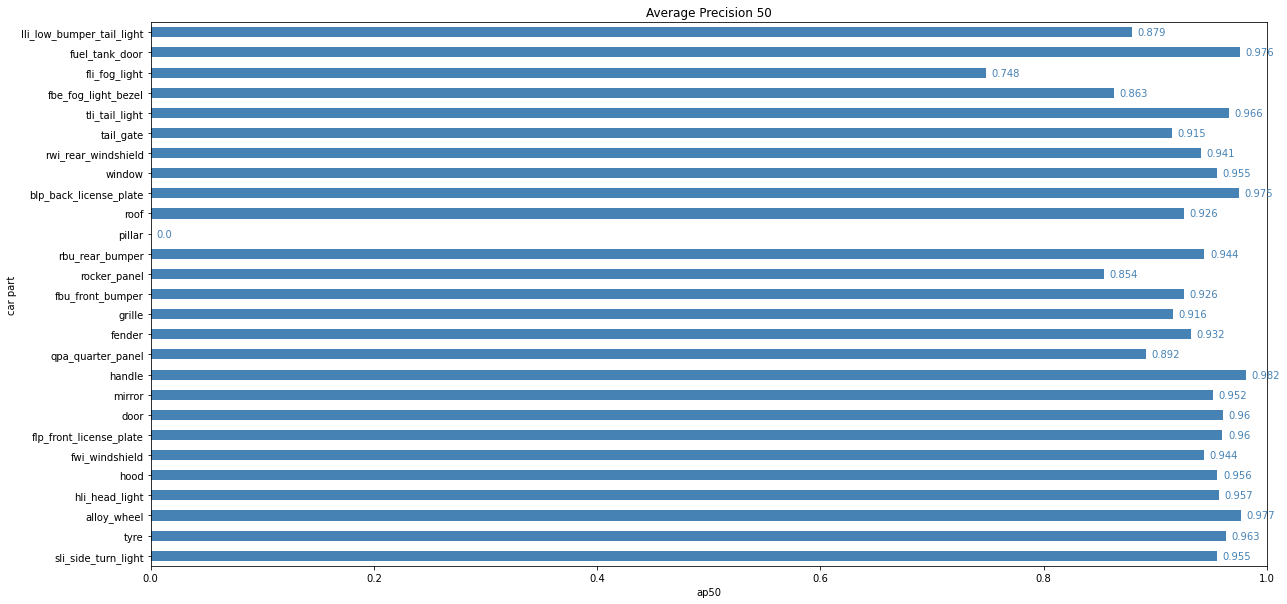

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_title('Average Precision 50')
ax.set_xlabel('ap50')
ax.set_ylabel('car part')


plot_cates = cates[:-1]
sampledata = {'categories': plot_cates, 
              'ap50': ap50}
test = pd.DataFrame(sampledata,  index=sampledata['categories'])
test.plot(kind = "barh", color = "steelblue", legend = False, grid = False, ax = ax) 
plt.xlim(0,1)
#print(test.ap50)
for i, v in enumerate(test.ap50):
    #print(i,v)
    plt.text(v+0.005, i, str(round(v, 3)), color='steelblue', va="center")
#fig.savefig('ap5.jpg')

OrderedDict([('door', [1])])


In [20]:
part_name = 'rocker_panel'
print('id : ' , plot_cates.index(part_name))
print('tps :', total_tps[plot_cates.index(part_name)])
print('preds :', total_preds[plot_cates.index(part_name)])

#total_tps[plot_cates.index('rocker_panel')]

id :  14
tps : 579
preds : 678


In [44]:
#total_tp ,total_fp,total_fn = 0,0,0
conf_matrix[:,:] = 0
for i in test['images']:
    image = cv2.imread(str(path/'images'/i['file_name']))
    #print(i['file_name'])
    
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]

    result = inference_detector(model, image)
    _,pred_boxs,_,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    tp,fp,fn = cal(image,pred_boxs,pred_labels,gt_boxes,gt_labels,i['file_name'])
    
    #total_tp += tp
    #total_fp += fp
    #total_fn += fn

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1474_DSCN5697.JPG
fender qpa_quarter_panel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8634.JPG
door handle
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_551_IMG_7778.JPG
rbu_rear_bumper fbu_front_bumper
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010121822338_img2296435.jpg
door window
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901385_img2899401.jpg
tli_tail_light hli_head_light
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_573_IMG_1566.JPG
fbu_front_bumper grille
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_560_IMG_0199.JPG
alloy_wheel tyre
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0027.jpg
handle door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0027.jpg
fli_fog_light fbe_fog_light_bezel
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1213_IMG_2018

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_932_9962+(7).jpg
flp_front_license_plate fli_fog_light
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_932_9962+(7).jpg
flp_front_license_plate fli_fog_light
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2062172.jpg
window rwi_rear_windshield
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM.jpeg
tyre fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_865_IMG_4810.JPG
grille hli_head_light
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141627.jpg
qpa_quarter_panel fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_632_TimePhoto_20180307_141627.jpg
rbu_rear_bumper fender
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(5).JPG
handle door
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1337_DSCN0992.JPG
qpa_quarter_panel fender
https:_

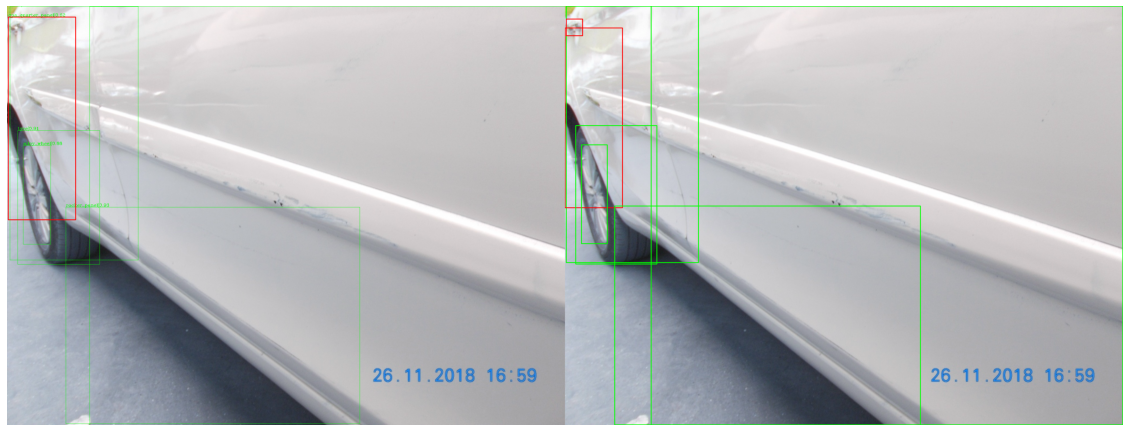

In [45]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1474_DSCN5697.JPG'
plot(name)

In [16]:
print(conf_matrix)

[[ 164    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  114]
 [   0 1179    2    1    0    0    0    1    0    0    2    1    0    0
     1    0    0    0    0    0    0    0    0    0    0    0    0   59]
 [   0    1  973    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   45]
 [   1    0    0  459    0    0    0    0    1    0    0    0    0    1
     0    0    0    0    0    0    0    0    3    0    1    0    0   66]
 [   0    0    0    0  347    0    0    1    0    0    1    5    2    2
     0    0    0    0    0    0    0    0    0    0    0    0    0   49]
 [   0    0    0    2    0  216    0    0    0    0    0    0    0    0
     0    0    0    0    0    2    4    1    0    0    0    0    0   25]
 [   0    0    0    0    0    0  192    0    0    0    0    0    0    0
     0    0    0    0    2    0    0    0    0    1    2  

In [13]:
np.save('confusion.npy',conf_matrix)

In [15]:
f_matrix = np.load('confusion.npy')
print(f_matrix)

[[ 164    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  114]
 [   0 1179    2    1    0    0    0    1    0    0    2    1    0    0
     1    0    0    0    0    0    0    0    0    0    0    0    0   59]
 [   0    1  973    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   45]
 [   1    0    0  459    0    0    0    0    1    0    0    0    0    1
     0    0    0    0    0    0    0    0    3    0    1    0    0   66]
 [   0    0    0    0  347    0    0    1    0    0    1    5    2    2
     0    0    0    0    0    0    0    0    0    0    0    0    0   49]
 [   0    0    0    2    0  216    0    0    0    0    0    0    0    0
     0    0    0    0    0    2    4    1    0    0    0    0    0   25]
 [   0    0    0    0    0    0  192    0    0    0    0    0    0    0
     0    0    0    0    2    0    0    0    0    1    2  

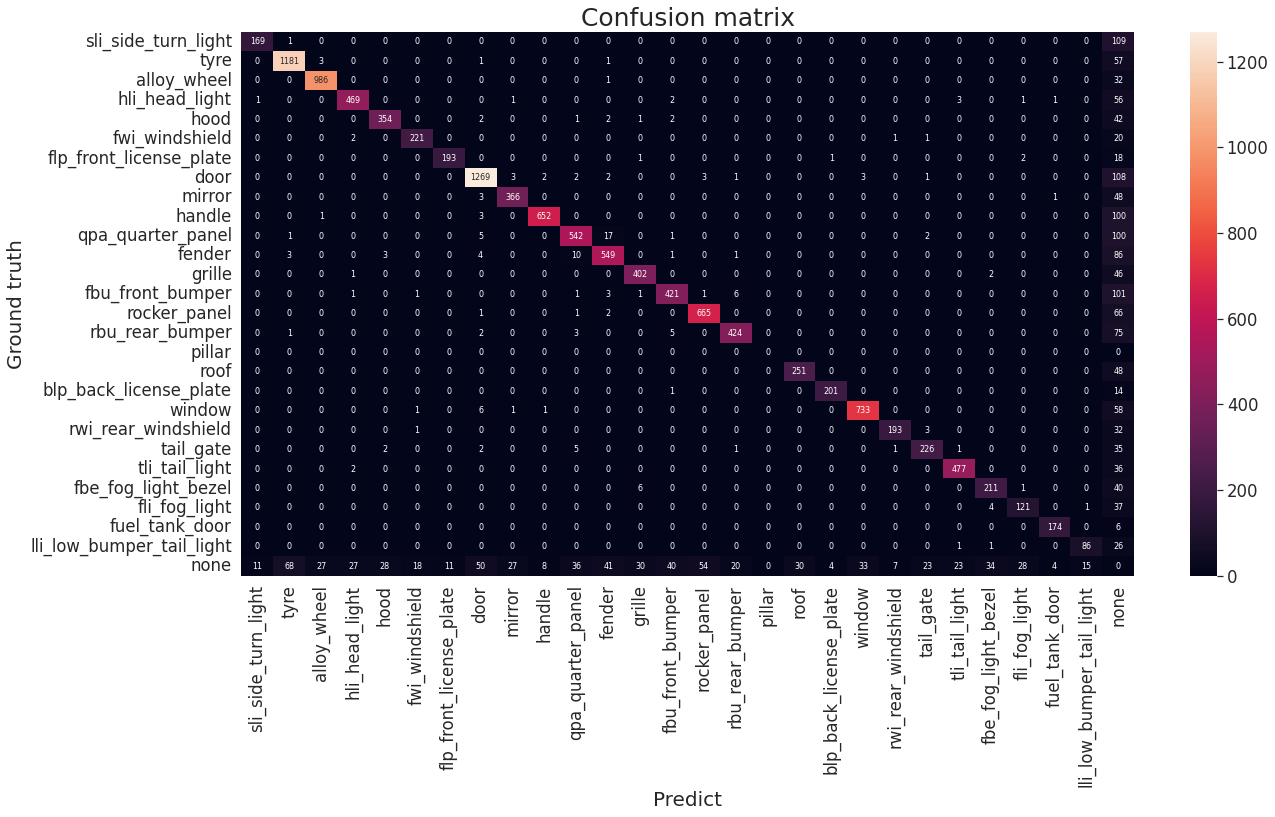

In [13]:
df_cm = pd.DataFrame(conf_matrix, index=cates,columns=cates)
sn.set(font_scale=1.5) # for label size
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='d') # font size
plt.xlabel('Predict', fontsize = 20) # x-axis label with fontsize 15
plt.ylabel('Ground truth', fontsize = 20)
plt.title('Confusion matrix',fontsize=25)
plt.savefig('confusion.png')
plt.show()

In [95]:
#plt.savefig('confusion.png')

<Figure size 432x288 with 0 Axes>

In [25]:
print('double check :',total_fn == conf_matrix[:,-1].sum())
print('total FN : ', total_fn )

double check : True
total FN :  1371


In [26]:
print('double check :',total_tp == sum([conf_matrix[i,i] for i in range(28)]))
print('total TP : ',total_tp)

double check : True
total TP :  11561


In [27]:
print('double check : ',total_fp == (conf_matrix.sum() - total_fn -total_tp))
print('total number of FP cases :', total_fp)

double check :  True
total number of FP cases : 923


In [28]:
# FP cases that predicted background
print('FP predict background : ',conf_matrix[-1,:].sum())

FP predict background :  728


In [29]:
# FP cases that predict wrong labels
print('FP predict wrong labels : ', total_fp-conf_matrix[-1,:].sum())

FP predict wrong labels :  195


In [ ]:
#phase_1 : 206\
tp : 11401  fp : 1048  fn :  1531
#pahse 2 : 173
tp : 11569  fp : 933  fn :  1363  
#rear pseudo : 179 
tp : 11536  fp : 876  fn :  1396
            
#rear   : 195
tp : 11561  fp : 923  fn :  1371

In [103]:
def plot(name):
    image = cv2.imread(str(path/'images'/name))
    i = [i for i in test['images'] if i['file_name']==name][0]
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    result = inference_detector(model, image.copy())
    image_out,pred_boxes,_,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    pred_tp = [0 for i in pred_boxes]
    gt_tp = [0 for i in gt_boxes]
       
    orgin_boxes = gt_boxes.copy()
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(image,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.5 :
                print(i_gt_boxes[j])
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_boxes[idx] = -1
                gt_labels[idx] = -1
                gt_tp[idx] = 1
                pred_tp[i] = 1
                break 
    for i in range(len(pred_tp)):
        if pred_tp[i]==0:
            image_out = cv2.rectangle(image_out,pred_boxes[i][0],pred_boxes[i][1],(255,0,0),2)
    
    for i in range(len(gt_tp)):
        if gt_tp[i]==1:
            image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(0,255,0),2)
        else:
            image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(255,0,0),2)
    
    out = np.hstack((image_out,image))
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(out)
    
    #return out

[(1904, 11), (2046, 329)]
[(238, 112), (627, 661)]
[(263, 218), (444, 587)]
[(1943, 72), (2046, 279)]
[(0, 0), (187, 299)]
[(1761, 0), (1875, 142)]
[(149, 0), (724, 330)]
[(0, 202), (247, 388)]
[(1778, 134), (1822, 157)]
[(313, 0), (1791, 643)]
[(1358, 0), (1653, 82)]
[(725, 0), (1271, 90)]
[(955, 504), (1101, 534)]


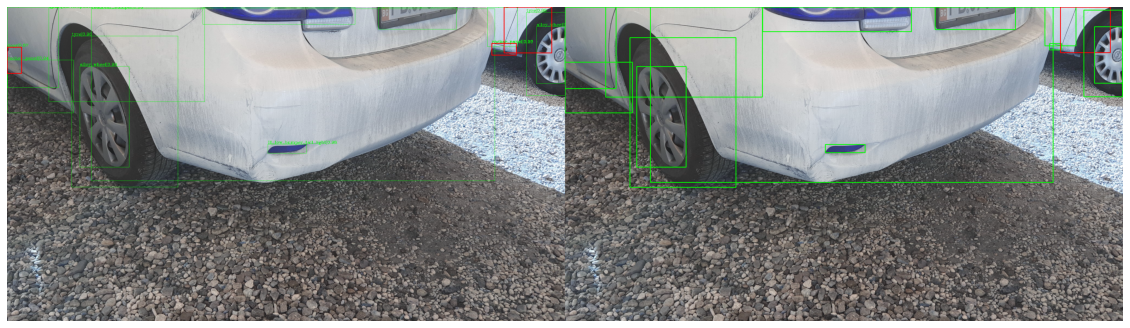

In [104]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900511_img2782647.jpg'
plot(name)

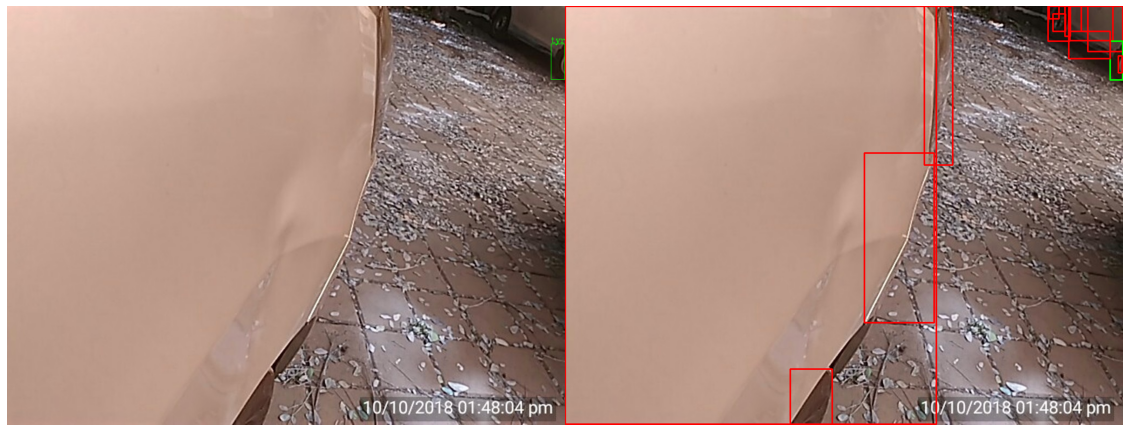

In [19]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_235_IMG-20181010-WA0083.jpg'
plot(name)

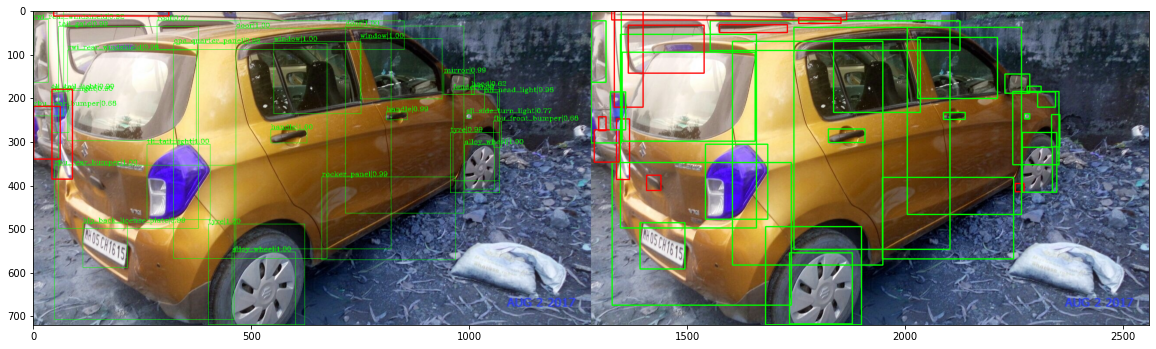

In [88]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9853.JPG'
plot(name)

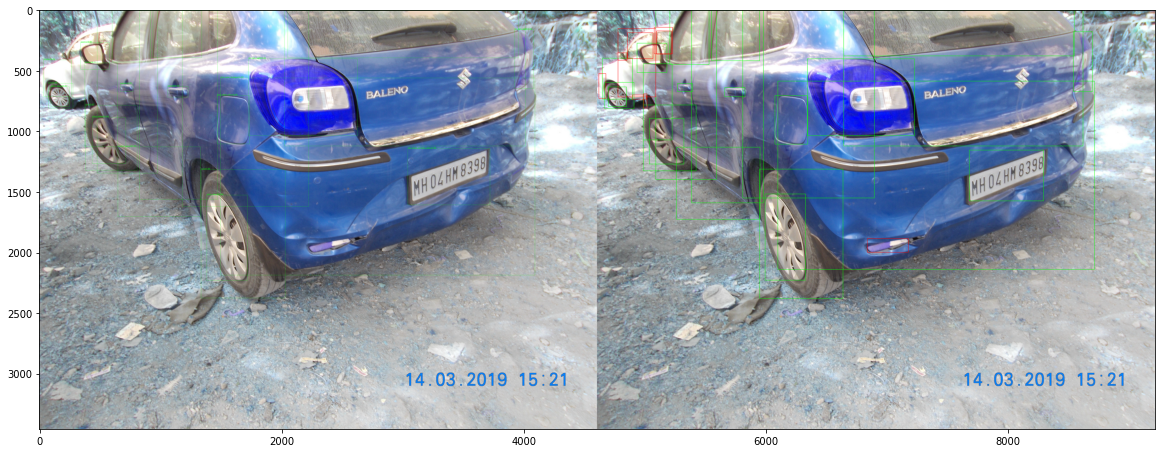

In [89]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_192_DSCN8517.JPG'
plot(name)

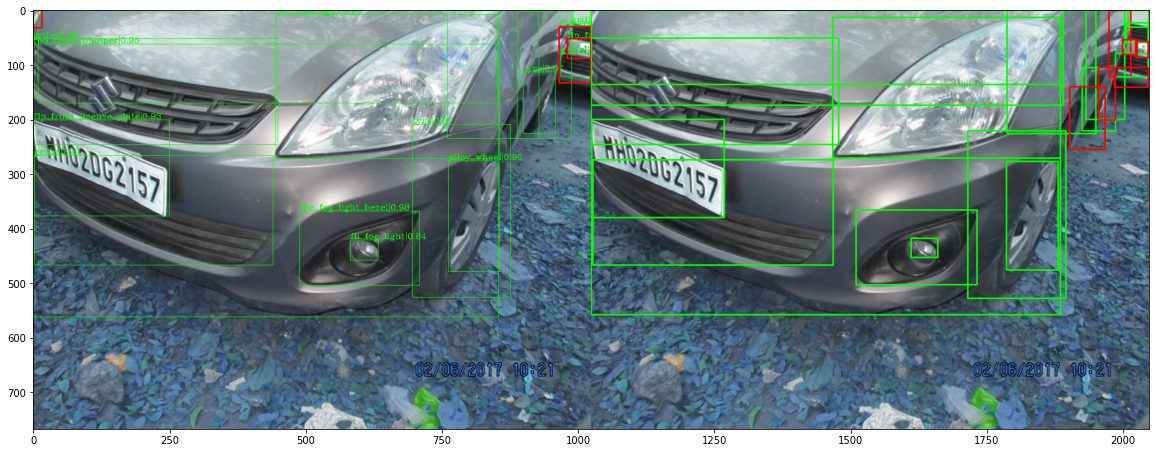

In [90]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_625_IMG_4345.JPG'
plot(name)

In [22]:
b = test['annotations'][0]['bbox']

In [26]:
print(b)
b1 = [(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))]
print(b1)

[441.99604743083, 822.1660013915051, 561.3438735177866, 256.12648221343863]
[(441, 822), (1002, 1078)]


In [16]:
box1 = [(109, 457), (262, 608)]
box2 =  [(209, 557), (362, 708)]

mask1 = np.zeros_like(img[:,:,0])
mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1

mask2 = np.zeros_like(img[:,:,0])
mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1

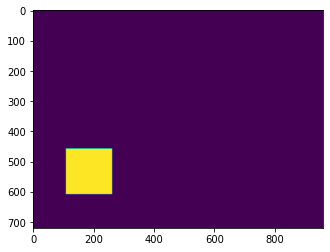

In [17]:
plt.imshow(mask1)

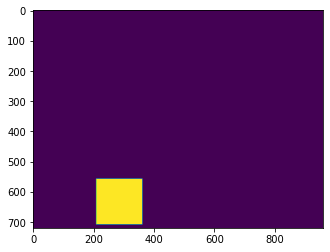

In [26]:
plt.imshow(mask2)

In [27]:
iou = np.logical_and(mask1,mask2)

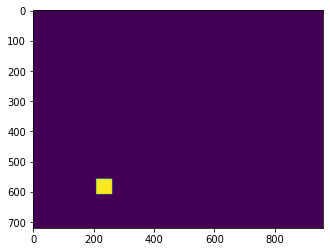

In [28]:
plt.imshow(iou)

In [30]:
a,b = 0,0
print(a,b)

0 0


In [31]:
a = [1,2,3,4,5]
b = ['a','b','c','d','e']

In [34]:
[i for (i,j) in zip(a,b) if j == 'e']

[5]

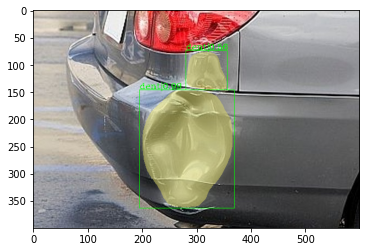

In [38]:
plt.imshow(cv2.cvtColor(out[0], cv2.COLOR_BGR2RGB))
plt.show()